In [36]:
import logging

from utils import logging as lg


lg.set_logging(logging.ERROR)

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cmocean


tf.logging.set_verbosity(tf.logging.ERROR)

import math

from utils import data_provider
from utils import experiment_artifact
from utils import network_architecture

from notebook_utils import plot

from model import provider as model_provider

from heatmap_tutorial import modules, utils
import matplotlib.gridspec as gridspec

plot.setup()


# Preparation

## Data Loader

In [3]:
dataset_loader = data_provider.DatasetLoader(data_dir='../data')

## Functions

In [4]:
def model_path(network, dataset, seq):
    return '../final-models/%s-%s-seq-%d' % (network, dataset, seq)

In [5]:
def plot_weight_bias(model_path):
    model_obj = model_provider.load(model_path)
    weights, bias = model_obj.get_weight_bias_at_layers()
    ws = []
    bs = []
    keys = []

    plt.figure(figsize=(15,4))
    for k in sorted(weights.keys()): 
            w = weights[k].reshape(-1,1)
            b = bias[k].reshape(-1,1)
            b = np.log(1+np.exp(b))

            ws.append(w)
            bs.append(b)
            
            keys.append(k)
            if (model_obj._.architecture_name == 's2_network' and k == 'input') or (model_obj._.architecture_name in ['s3_network', 'deep_4l_network'] and k == 'input_to_cell') :
                rr_units = network_architecture.parse(model_obj._.architecture)['recur']
                ws.append(w[:rr_units,:])
                bs.append(b[:rr_units,:])
                keys.append('%s--data' % k )
                
                ws.append(w[-rr_units:,:])
                bs.append(b[-rr_units:,:])
                keys.append('%s--recur' % k )
    plt.suptitle('Variable distributions\n%s:%s\n%s (no. variables %d ) \n(opt %s, acc %.4f, keep_prob %.2f)' %
                     (
                      model_obj._.architecture_name,
                      model_obj._.architecture,
                      model_obj._.experiment_name,
                      model_obj.dag.no_variables(),
                      model_obj._.optimizer,
                      model_obj._.accuracy,
                      model_obj._.keep_prob
                     ), y = 1.2)

            
    ticks = range(1, len(ws)+1)
    plt.subplot(1,2,1)
    plt.boxplot(ws, keys)
    plt.title('Weights')
    plt.yticks([-1.5,-0.75,0,0.75,1.5])
    plt.xticks(ticks, keys, rotation='vertical')
    plt.subplot(1,2,2)
    plt.boxplot(bs, keys)
    plt.title('Biases')
    plt.xticks(ticks, keys, rotation='vertical')
    plt.show()

In [6]:
def get_test_data_in_class(ds, label):
    x, y = dataset[ds].test2d.x, dataset[ds].test.y
    if label is None:
        return x, y
    selector = np.argmax(y, axis=1) == label

    return x[selector, :, :], y[selector]

def plot_digits(data, limit=200):
    plt.figure(figsize=(20,20))
    count = 1
    for i in range(limit):
        plt.subplot(10,20, count)
        plt.imshow(data[i,:].reshape(28,28))
        plt.xticks([])
        plt.yticks([])
        plt.title(i)
        count = count + 1
    plt.tight_layout()
    plt.show()

def rel_dist_deep_taylor(model_obj, data, y):
    
    _, heatmap = model_obj.lrp(data, y, debug=False)

    relevance_dist = np.sum(heatmap.transpose(2,1,0).reshape(model_obj._.seq_length,-1),axis=1)

    return relevance_dist, heatmap

def plot_lrp_relevance_dist_all(model_obj):
    fig = plt.figure(figsize=(15,7.5))
    
    rel_dists = []


    for i in [None] + list(range(0,10)):
        x, y = get_test_data_in_class(model_obj._.dataset, i)
        rel_dist_dt, _ = rel_dist_deep_taylor(model_obj, x, y)
        rel_dists.append(rel_dist_dt)

        
    data_obj = dataset[model_obj._.dataset]
    labels = ['All Test Data'] + list(map(lambda x: data_obj.get_text_label(x), range(0,10)))
    x_ticks = np.arange(model_obj._.seq_length) + 1
    
    plt.suptitle('Relevance distribution from LRP Deep Taylor\n model: %s\n%s(acc %.4f)' %
             (
                 model_obj._.experiment_name,
                 model_obj._.architecture,
                 model_obj._.accuracy,
             ),
            )
    
    for i, r in zip(range(len(rel_dists)), rel_dists):
        if i == 0:
            ax = plt.subplot2grid((4, 3), (0, 0), rowspan=2)
        else:
            row_id = int(i/3)
            col_id = i%3
            if row_id >= 1:
                col_id = col_id + 1
                if col_id >= 3:
                    row_id = row_id+1
                    col_id = (col_id)%3
            ax = plt.subplot2grid((4, 3), (row_id, col_id))
    #         print('%d and (%d,%d)' % (i, row_id, col_id))
    # ax0.plot()
        rel_dist = rel_dists[i]

        def plot_bar_chart(axis, data):
            axis.bar(x_ticks, data, 0.5, color='r')
            axis.set_xticks(x_ticks)
        plot_bar_chart(ax, rel_dist)

        ax2 = ax.twinx()

        if i == 0:
            ax.set_ylabel('Aggregated relevance')
            ax.set_xlabel('Step $i$-th')
            ax2.set_ylabel('Percentage')

        relative_dist = rel_dist / np.sum(rel_dist)
        plot_bar_chart(ax2, relative_dist)

        ax.set_title(labels[i])

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

In [7]:
# def count_positive_relevance(model_obj, dataset):
#     x = dataset.test2d.x
#     y = dataset.test2d.y
    
#     rr_inputs = np.zeros((x.shape[0], model_obj.architecture.recur))
    
#     with model_obj.get_session() as sess:
#         y_pred, y_pred_y_target = sess.run([model_obj.dag.y_pred, model_obj.dag.y_pred_y_target], feed_dict= {
#             model_obj.dag.x: x,
#             model_obj.dag.y_target: y,
#             model_obj.dag.rx: rr_inputs,
#             model_obj.dag.keep_prob: 1
#         })
        
#     relevance = np.sum(y_pred_y_target, axis=1)
#     print('Positive relevance for model %s' % model_obj._.experiment_name)
#     print('relevance >= 0 : %f' % (np.mean(relevance >= 0)))


        
def plot_rel_and_dist(m,
                      methods=['sensitivity', 'simple_taylor', 'guided_backprop',
                               'lrp_alpha2_beta1', 'lrp_alpha3_beta2', 'lrp_deep_taylor'], skip_data=False):

    plot.plot_relevance_methods(m, dataset_loader, methods)

#     plot_lrp_relevance_dist_all(model_obj)

In [8]:
def plot_everything(network, dataset, seq):
    path = model_path(network, dataset, seq)
    plot_rel_and_dist(path)
#     plot_weight_bias(path)

# Visualize

In [9]:
plot.show_model_accuracy('mnist', seqs=[1, 4, 7])

mnist accuracy


/Users/heytitle/projects/heatmapping-tutorial/src/model/components/layer.py:25: RuntimeWarning: divide by zero encountered in log
  self.b = tf.Variable(tf.ones(dims[-1]) * float(np.log(np.exp(DEFAULT_BIAS_VALUE)-1)), name=b_name)


seq  shallow    deep  deep_v2  convdeep
0    1   0.9811  0.9822   0.9778    0.9914
1    4   0.9856  0.9863   0.9846    0.9899
2    7   0.9866  0.9868   0.9841    0.9891

In [10]:
plot.show_model_accuracy('fashion-mnist', seqs=[1, 4, 7])

fashion-mnist accuracy


/Users/heytitle/projects/heatmapping-tutorial/src/model/components/layer.py:25: RuntimeWarning: divide by zero encountered in log
  self.b = tf.Variable(tf.ones(dims[-1]) * float(np.log(np.exp(DEFAULT_BIAS_VALUE)-1)), name=b_name)


seq  shallow    deep  deep_v2  convdeep
0    1   0.8793  0.8914   0.8848    0.9097
1    4   0.8904  0.8943   0.8907    0.9067
2    7   0.8928  0.8896   0.8889    0.9022

## Seq 1

### MNIST

/Users/heytitle/projects/heatmapping-tutorial/src/model/components/layer.py:25: RuntimeWarning: divide by zero encountered in log
  self.b = tf.Variable(tf.ones(dims[-1]) * float(np.log(np.exp(DEFAULT_BIAS_VALUE)-1)), name=b_name)


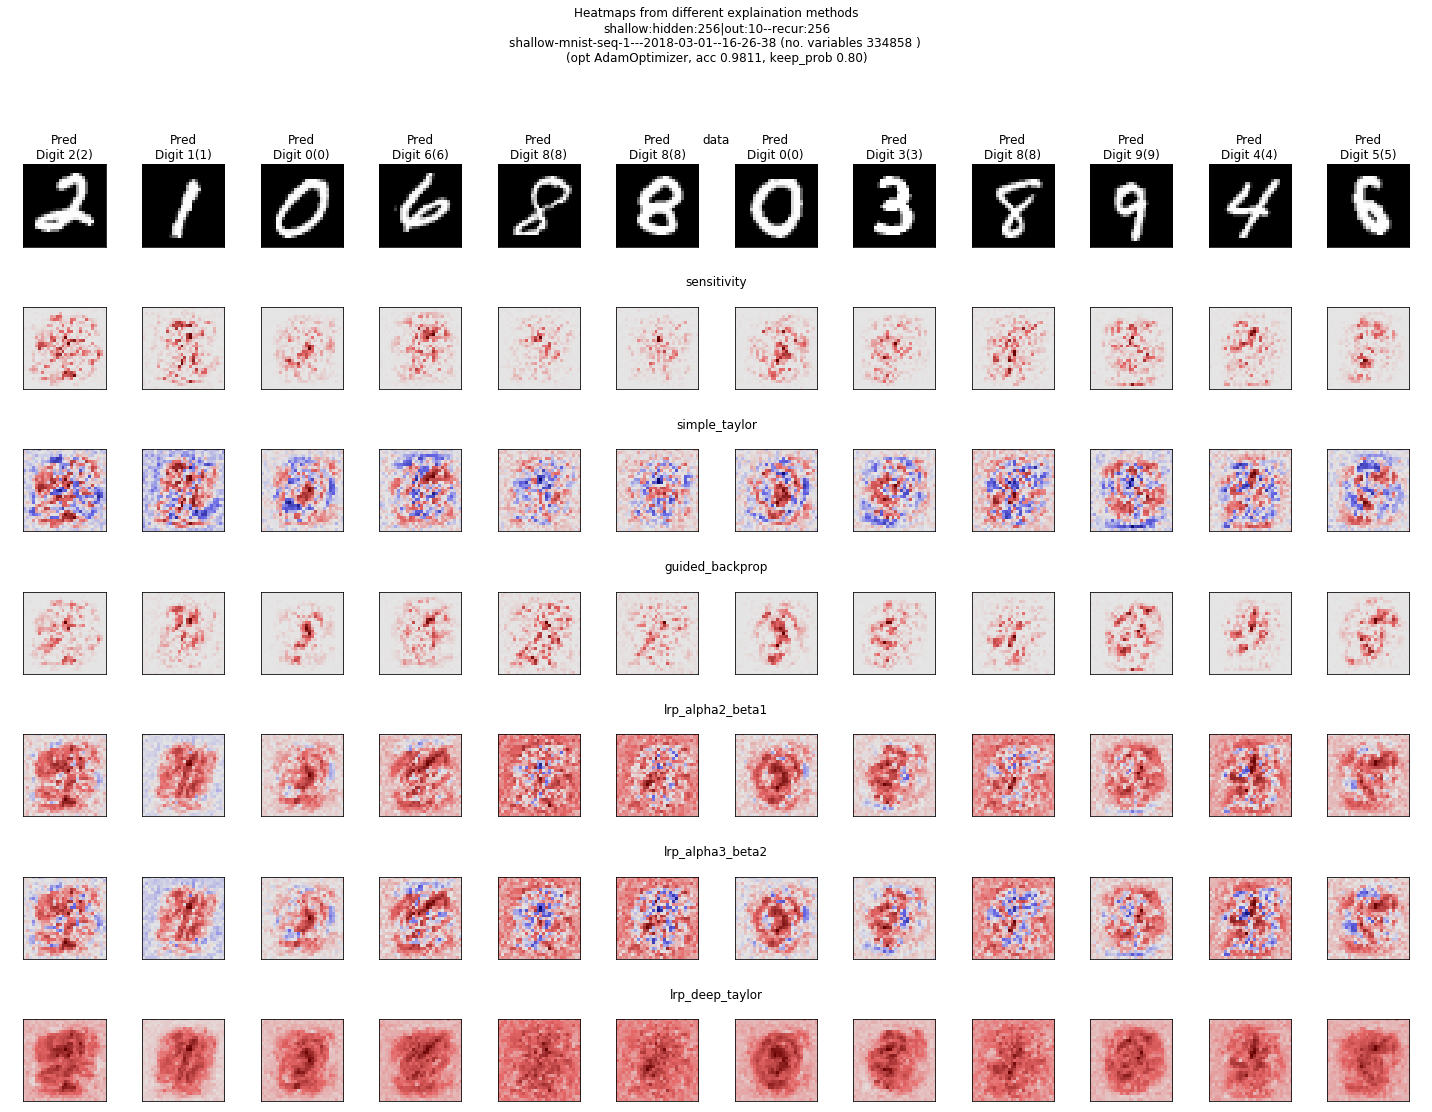

In [11]:
plot_everything('shallow', 'mnist', 1)

/Users/heytitle/projects/heatmapping-tutorial/src/model/components/layer.py:25: RuntimeWarning: divide by zero encountered in log
  self.b = tf.Variable(tf.ones(dims[-1]) * float(np.log(np.exp(DEFAULT_BIAS_VALUE)-1)), name=b_name)


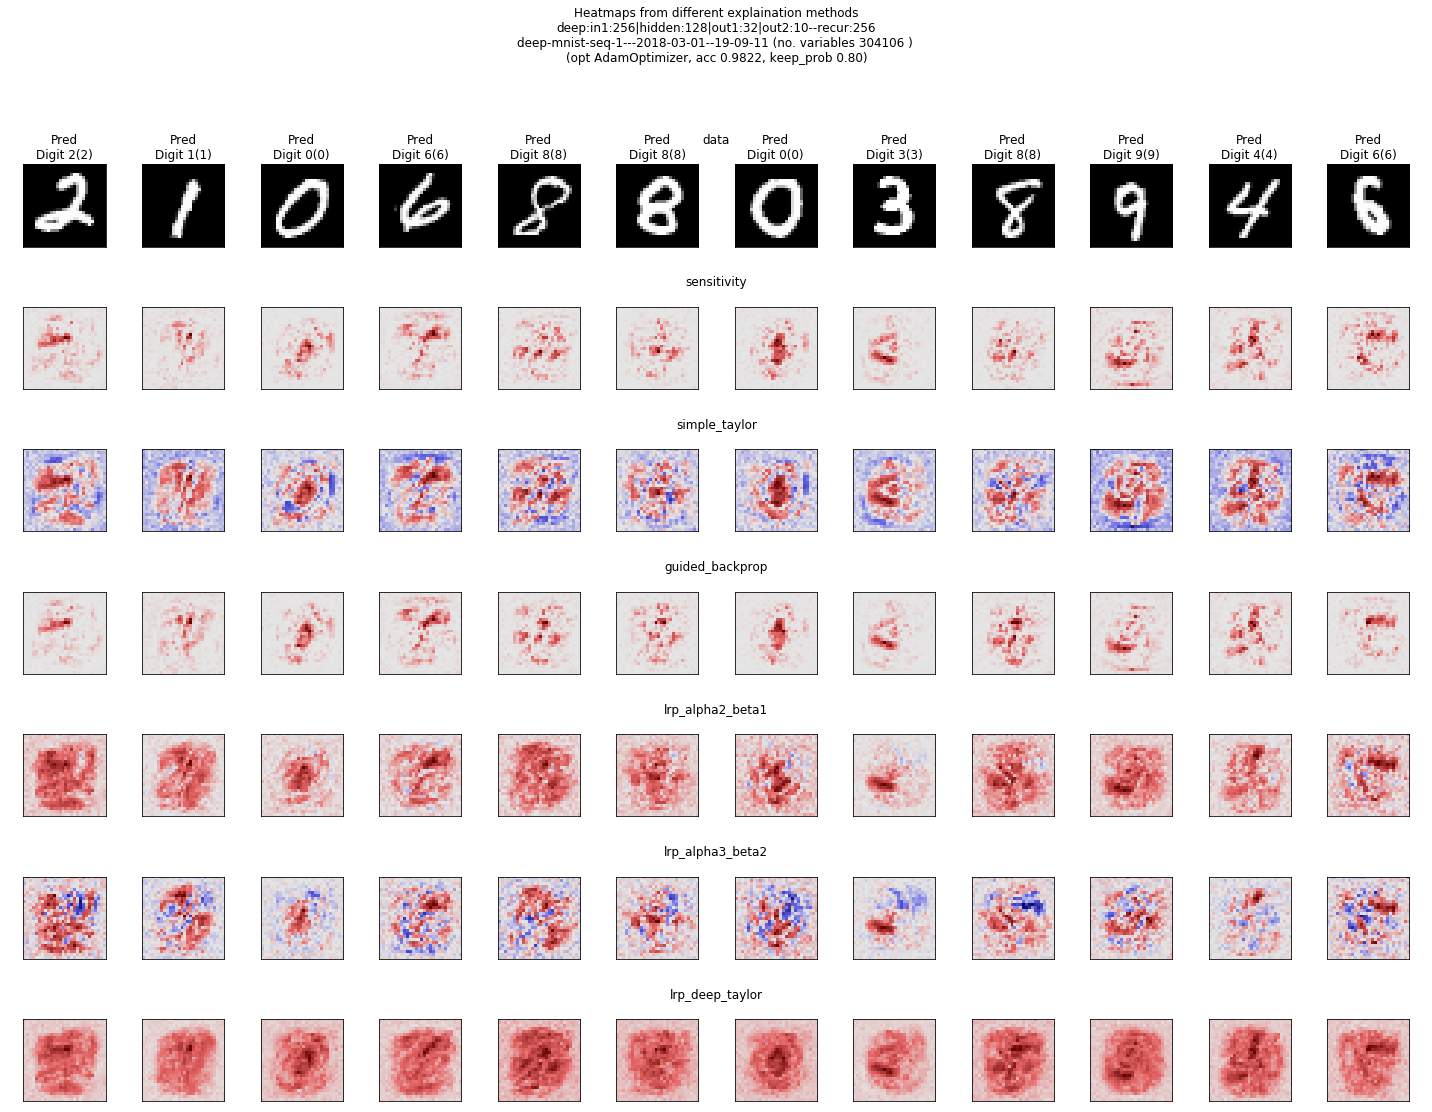

In [12]:
plot_everything('deep', 'mnist', 1)

/Users/heytitle/projects/heatmapping-tutorial/src/model/components/layer.py:25: RuntimeWarning: divide by zero encountered in log
  self.b = tf.Variable(tf.ones(dims[-1]) * float(np.log(np.exp(DEFAULT_BIAS_VALUE)-1)), name=b_name)


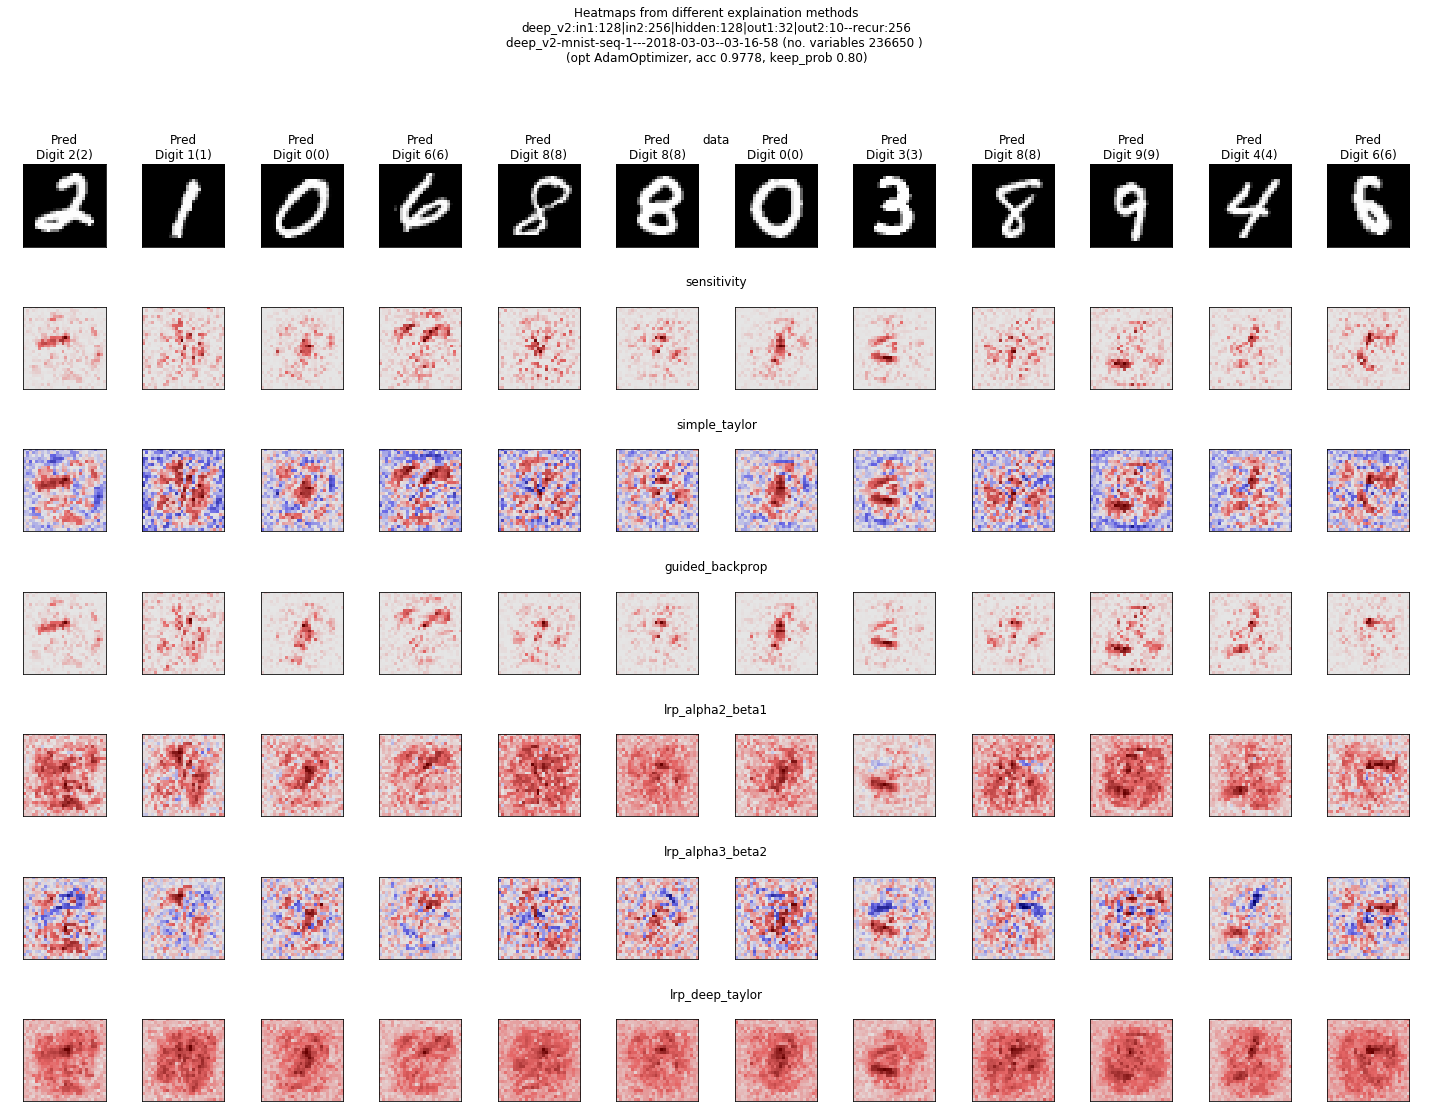

In [13]:
plot_everything('deep_v2', 'mnist', 1)

/Users/heytitle/projects/heatmapping-tutorial/src/model/components/layer.py:25: RuntimeWarning: divide by zero encountered in log
  self.b = tf.Variable(tf.ones(dims[-1]) * float(np.log(np.exp(DEFAULT_BIAS_VALUE)-1)), name=b_name)


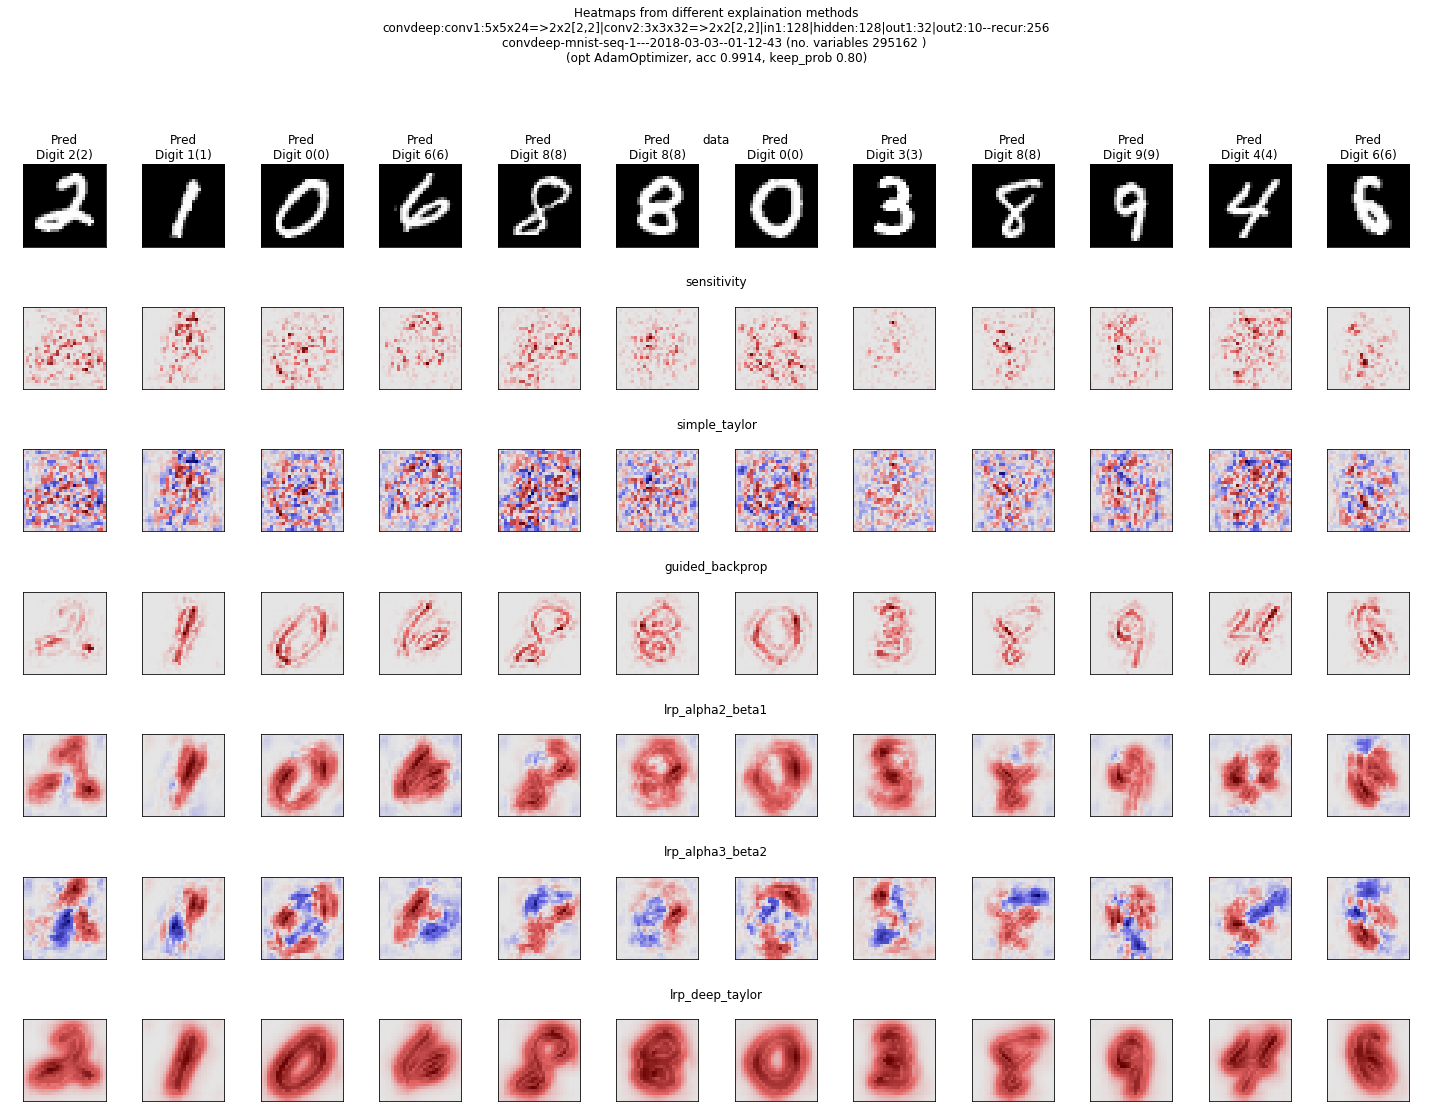

In [14]:
plot_everything('convdeep', 'mnist', 1)

### FashionMNIST

/Users/heytitle/projects/heatmapping-tutorial/src/model/components/layer.py:25: RuntimeWarning: divide by zero encountered in log
  self.b = tf.Variable(tf.ones(dims[-1]) * float(np.log(np.exp(DEFAULT_BIAS_VALUE)-1)), name=b_name)


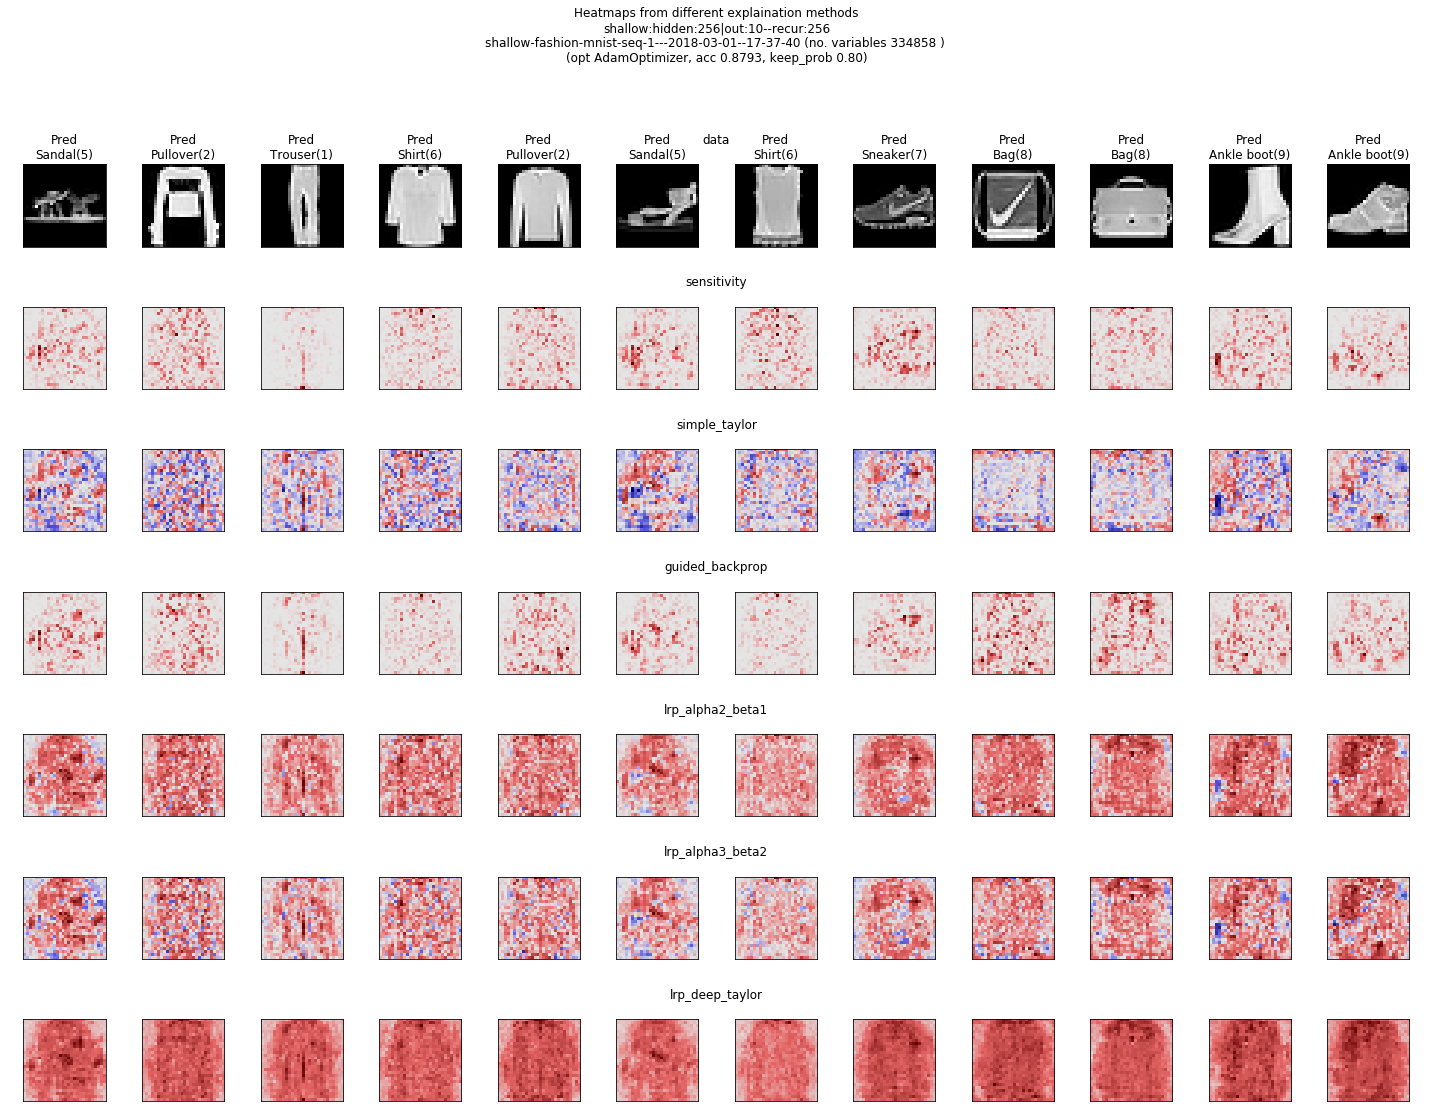

In [15]:
plot_everything('shallow', 'fashion-mnist', 1)

/Users/heytitle/projects/heatmapping-tutorial/src/model/components/layer.py:25: RuntimeWarning: divide by zero encountered in log
  self.b = tf.Variable(tf.ones(dims[-1]) * float(np.log(np.exp(DEFAULT_BIAS_VALUE)-1)), name=b_name)


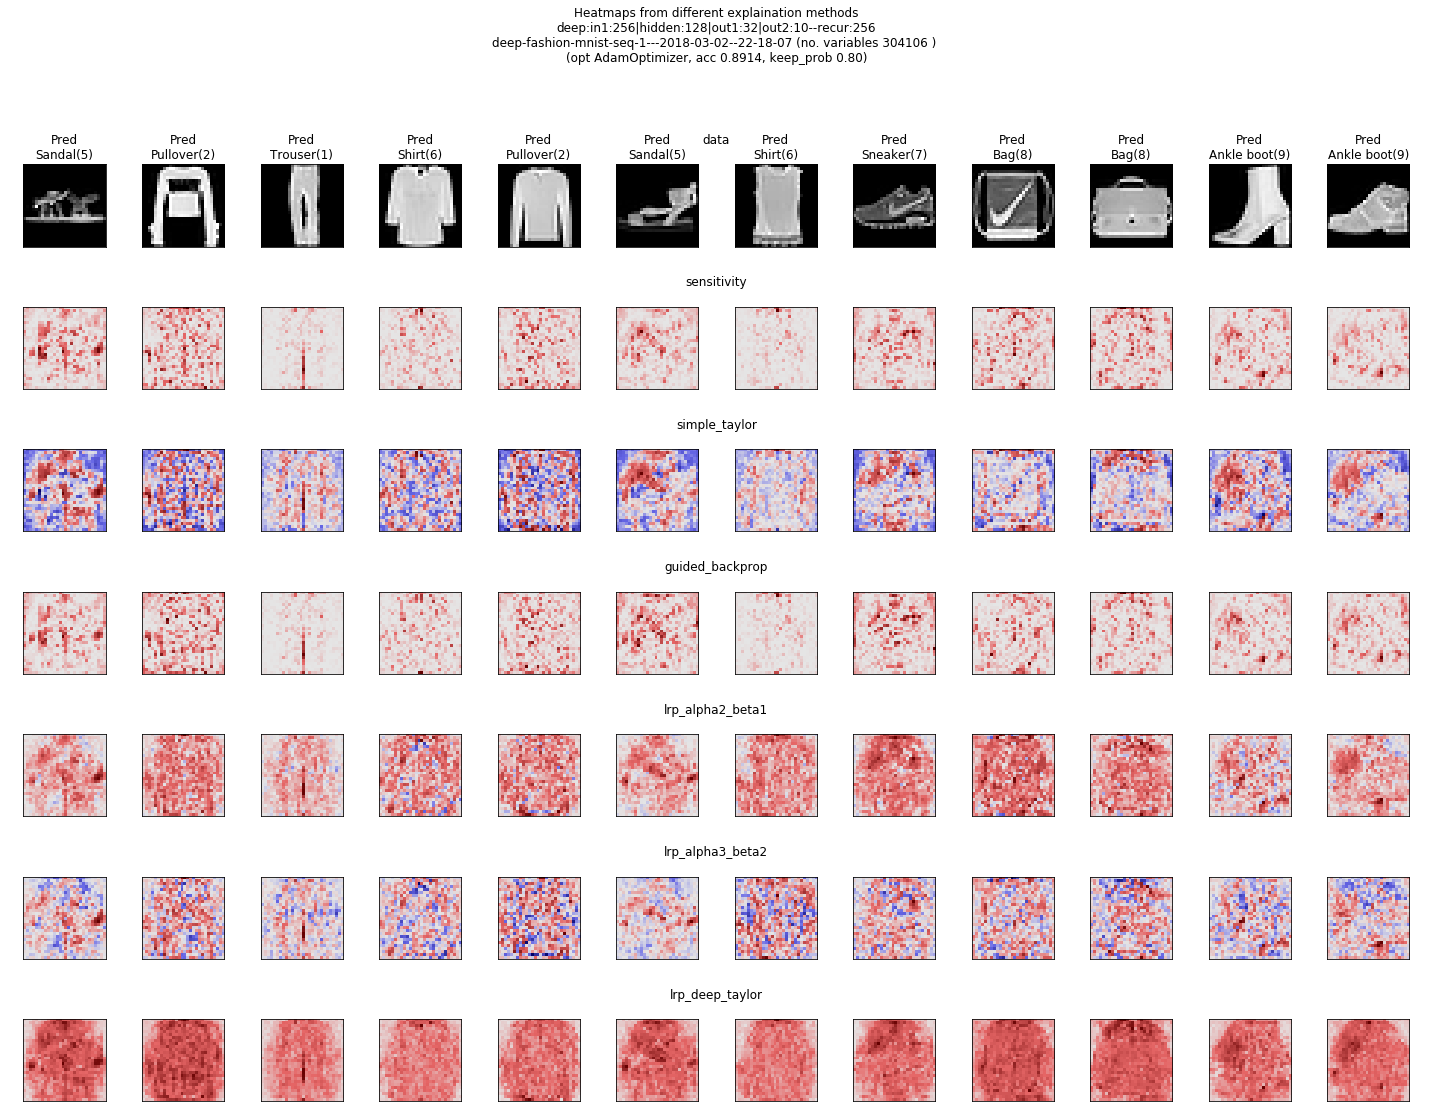

In [16]:
plot_everything('deep', 'fashion-mnist', 1)

/Users/heytitle/projects/heatmapping-tutorial/src/model/components/layer.py:25: RuntimeWarning: divide by zero encountered in log
  self.b = tf.Variable(tf.ones(dims[-1]) * float(np.log(np.exp(DEFAULT_BIAS_VALUE)-1)), name=b_name)


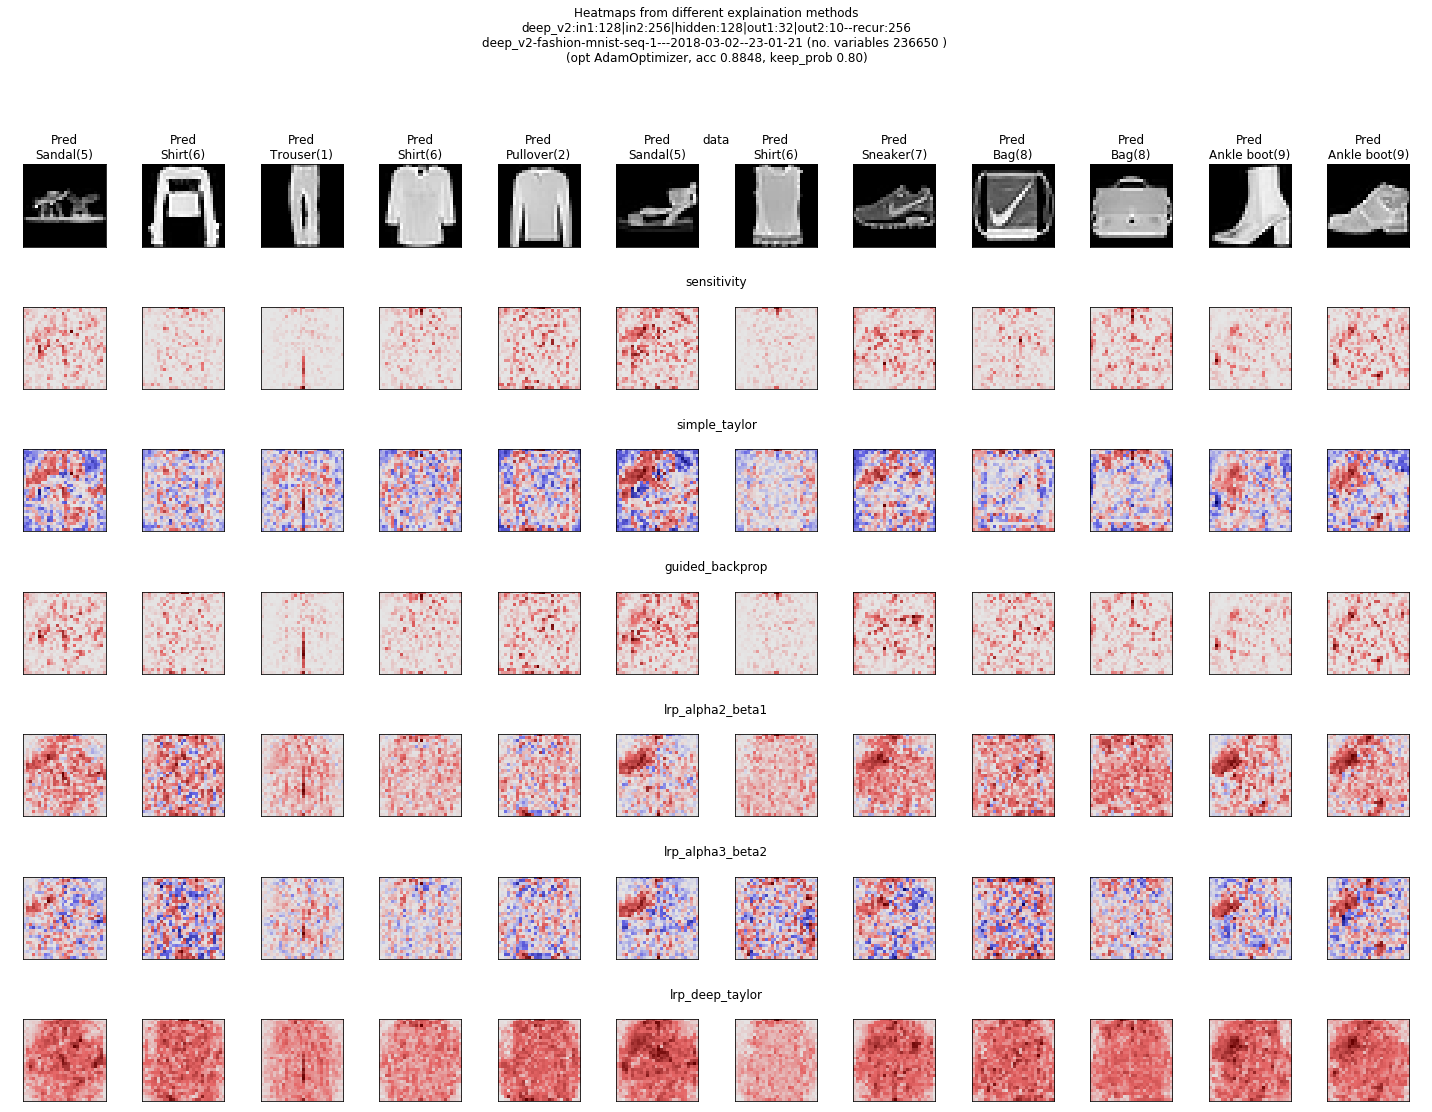

In [17]:
plot_everything('deep_v2', 'fashion-mnist', 1)

/Users/heytitle/projects/heatmapping-tutorial/src/model/components/layer.py:25: RuntimeWarning: divide by zero encountered in log
  self.b = tf.Variable(tf.ones(dims[-1]) * float(np.log(np.exp(DEFAULT_BIAS_VALUE)-1)), name=b_name)


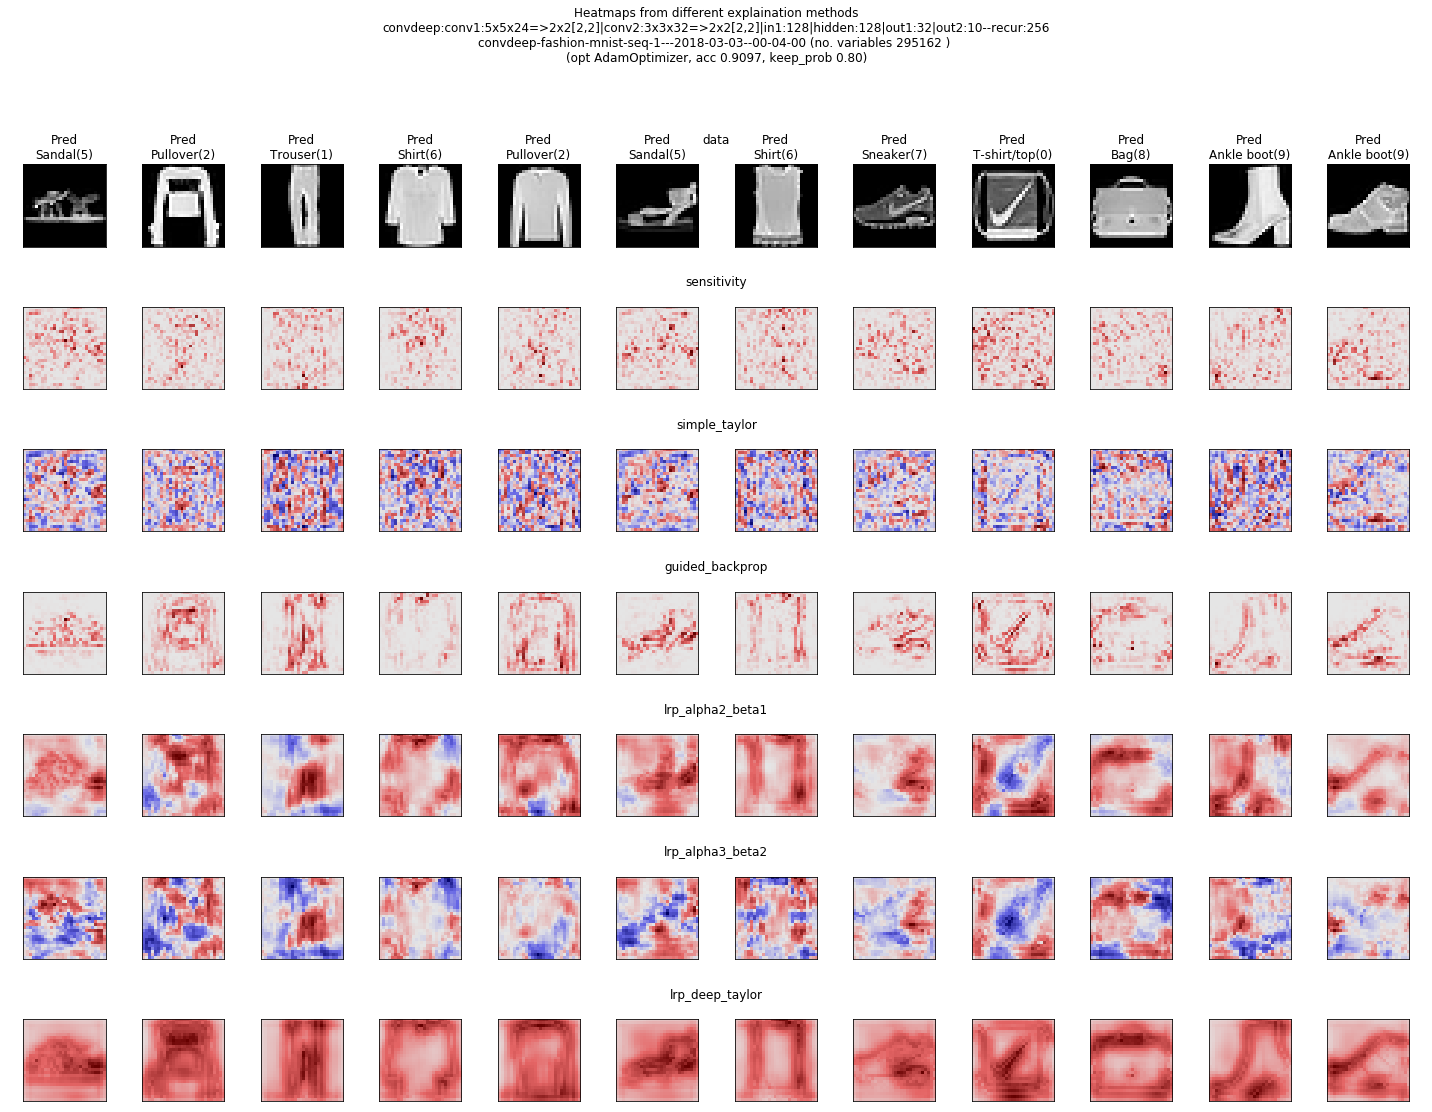

In [18]:
plot_everything('convdeep', 'fashion-mnist', 1)

## Seq 4

### MNIST

/Users/heytitle/projects/heatmapping-tutorial/src/model/components/layer.py:25: RuntimeWarning: divide by zero encountered in log
  self.b = tf.Variable(tf.ones(dims[-1]) * float(np.log(np.exp(DEFAULT_BIAS_VALUE)-1)), name=b_name)


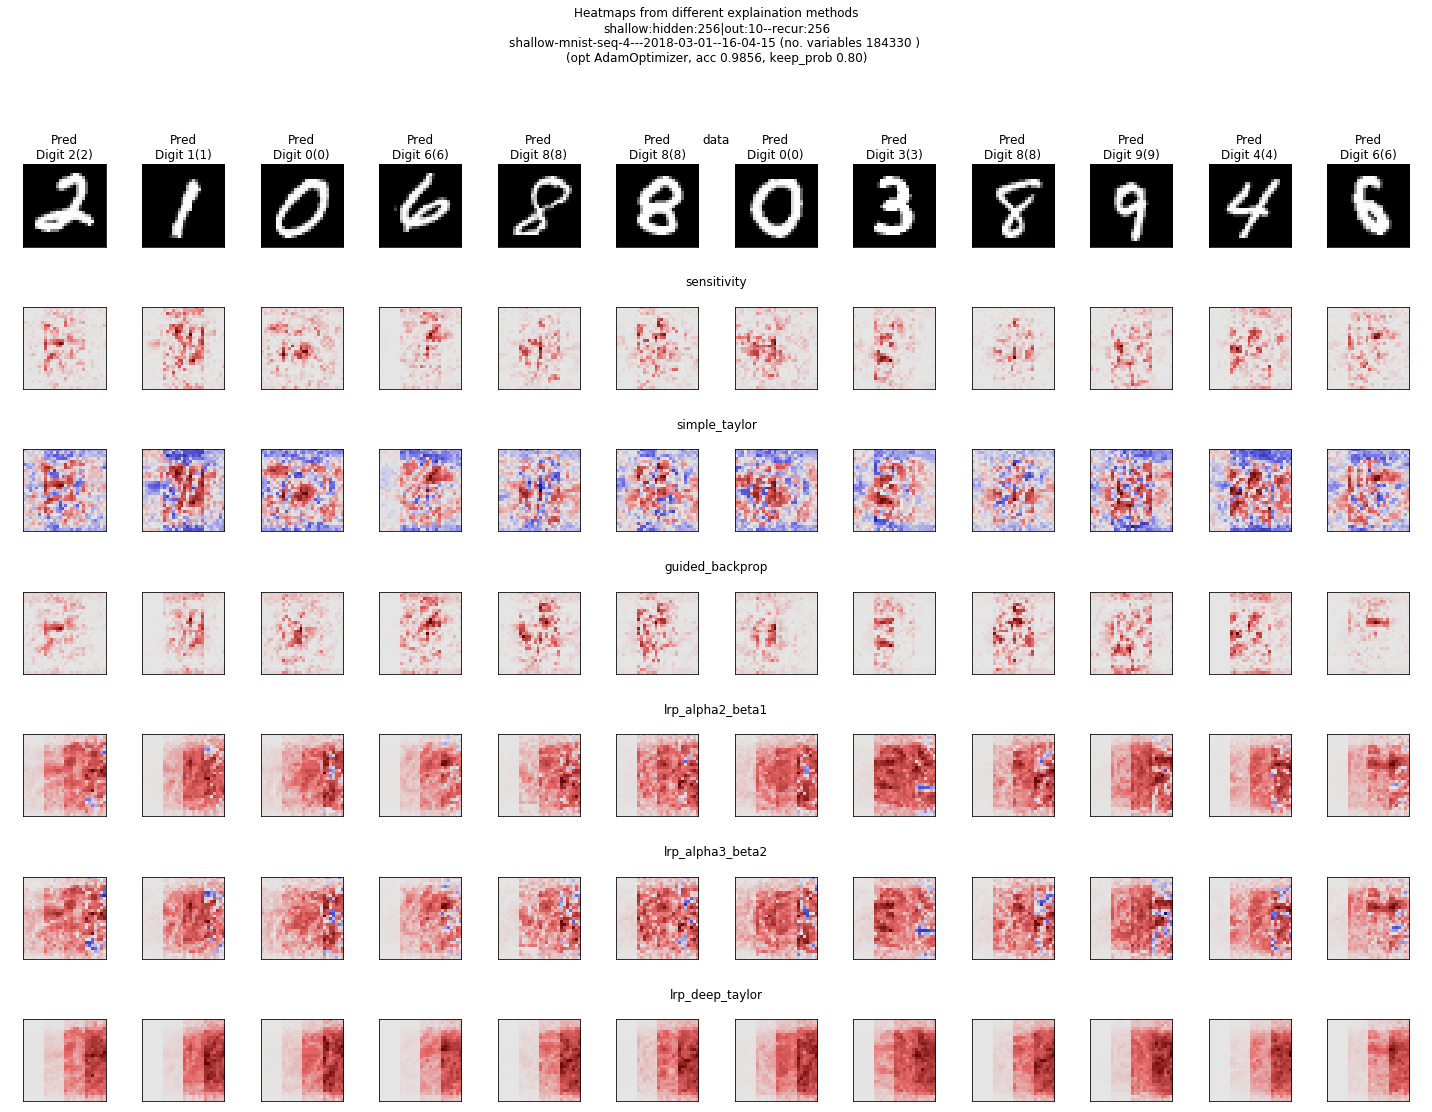

In [19]:
plot_everything('shallow', 'mnist', 4)

/Users/heytitle/projects/heatmapping-tutorial/src/model/components/layer.py:25: RuntimeWarning: divide by zero encountered in log
  self.b = tf.Variable(tf.ones(dims[-1]) * float(np.log(np.exp(DEFAULT_BIAS_VALUE)-1)), name=b_name)


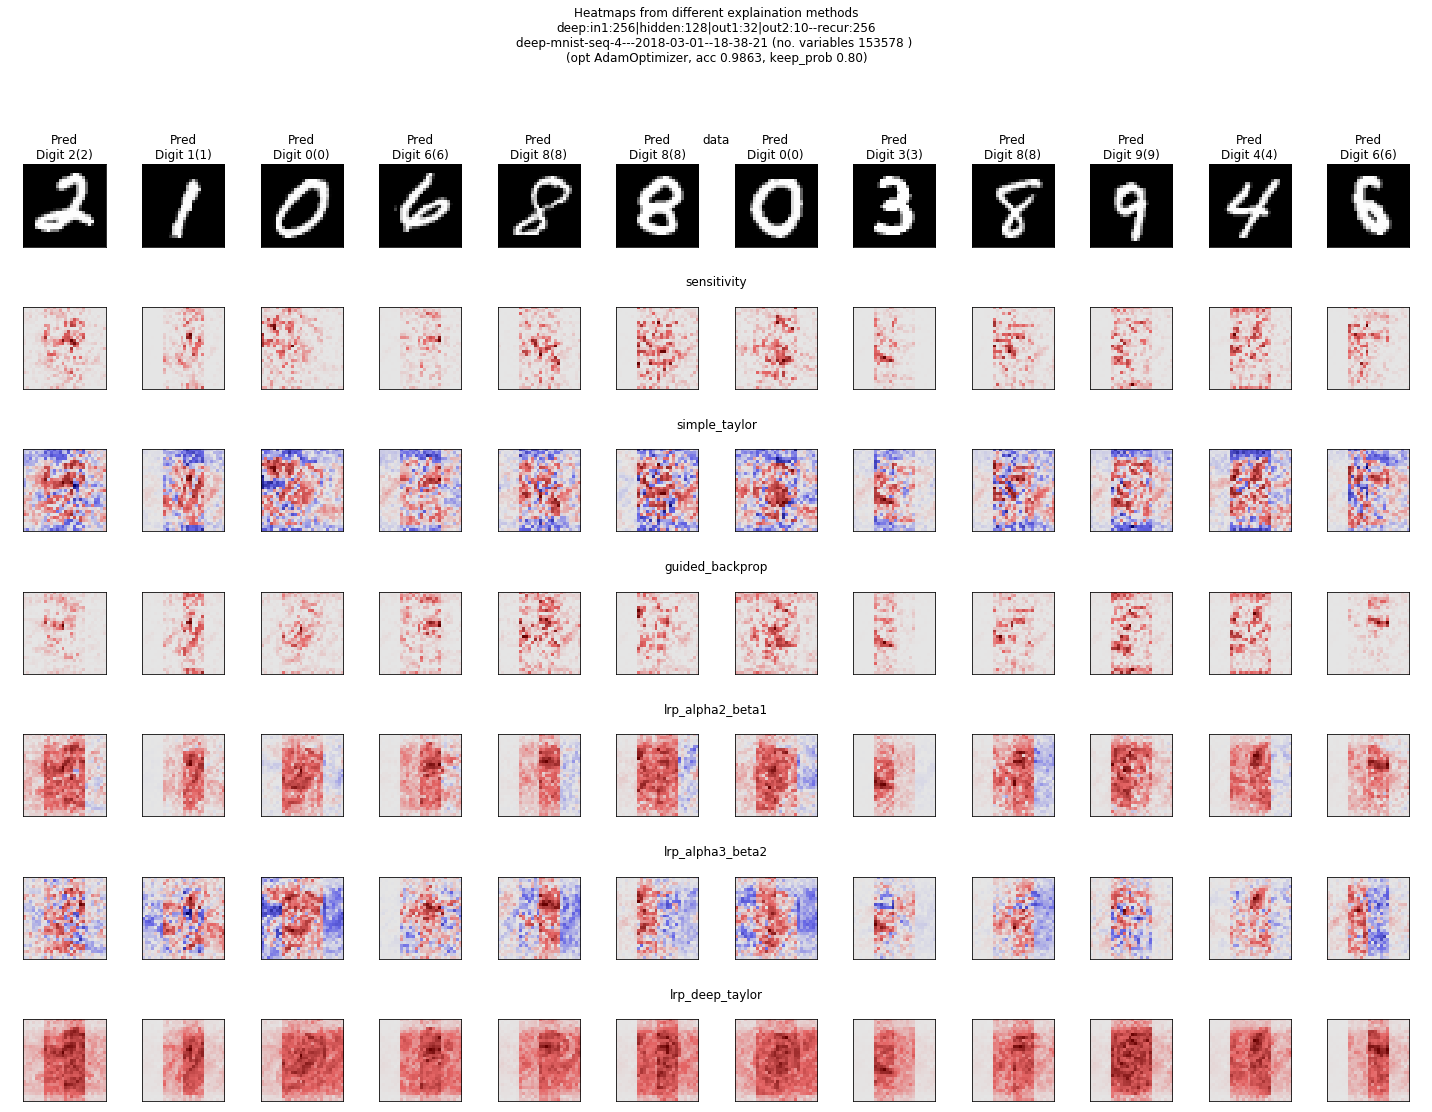

In [20]:
plot_everything('deep', 'mnist', 4)

/Users/heytitle/projects/heatmapping-tutorial/src/model/components/layer.py:25: RuntimeWarning: divide by zero encountered in log
  self.b = tf.Variable(tf.ones(dims[-1]) * float(np.log(np.exp(DEFAULT_BIAS_VALUE)-1)), name=b_name)


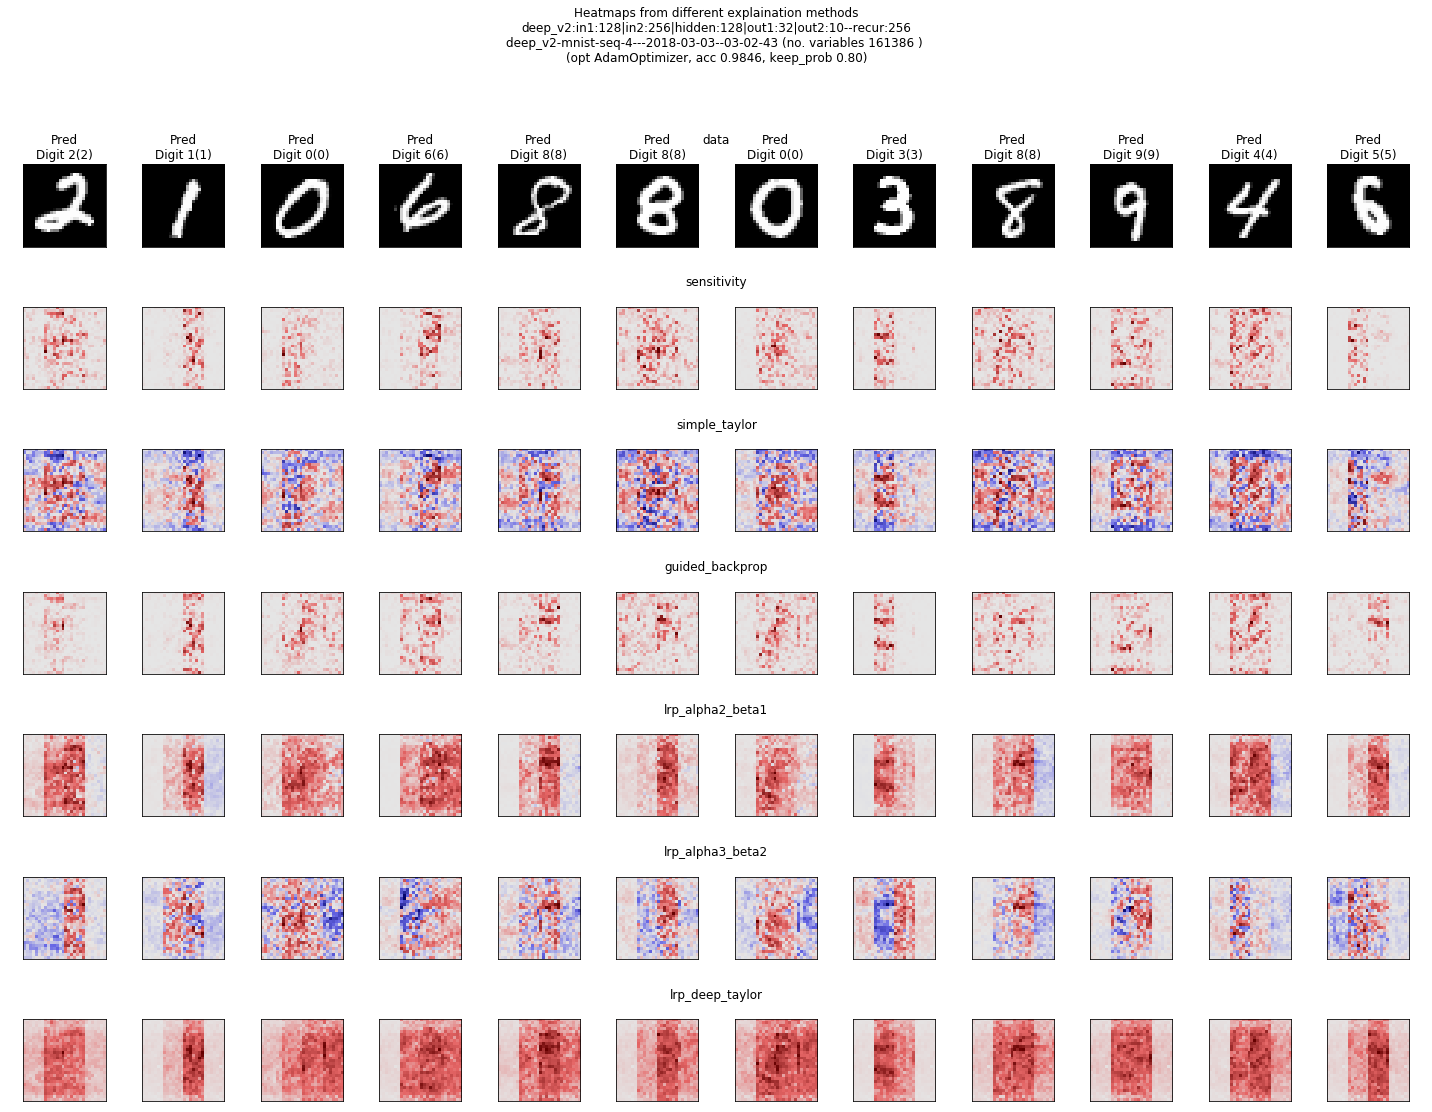

In [21]:
plot_everything('deep_v2', 'mnist', 4)

/Users/heytitle/projects/heatmapping-tutorial/src/model/components/layer.py:25: RuntimeWarning: divide by zero encountered in log
  self.b = tf.Variable(tf.ones(dims[-1]) * float(np.log(np.exp(DEFAULT_BIAS_VALUE)-1)), name=b_name)


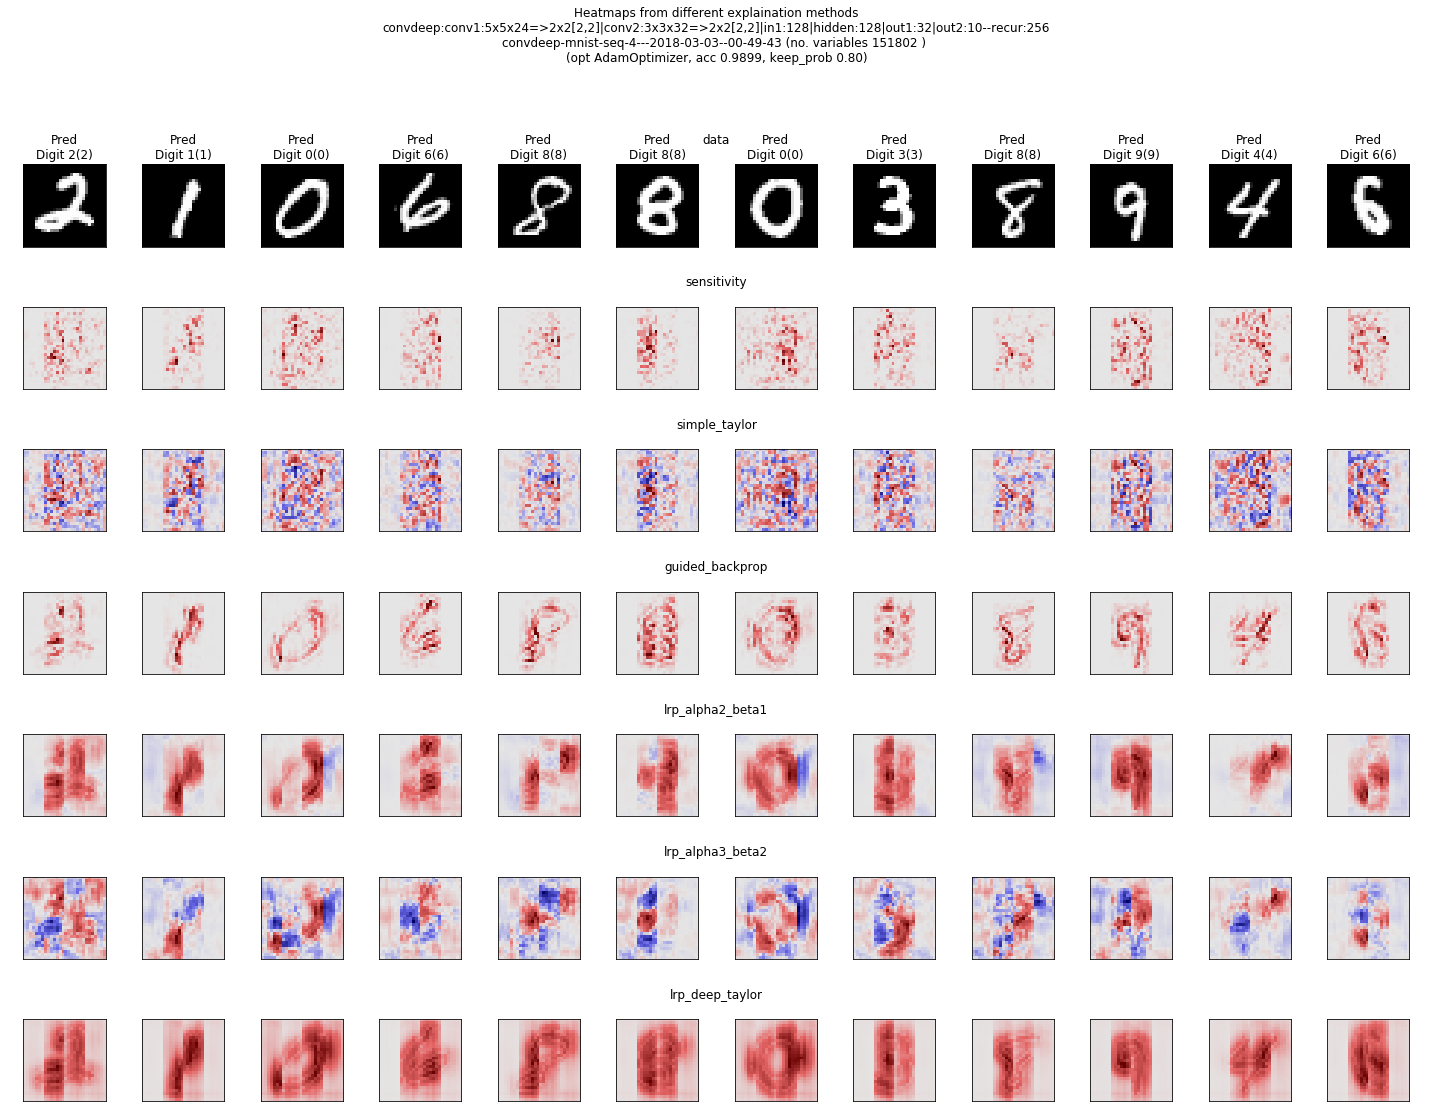

In [22]:
plot_everything('convdeep', 'mnist', 4)

### FashionMNIST

/Users/heytitle/projects/heatmapping-tutorial/src/model/components/layer.py:25: RuntimeWarning: divide by zero encountered in log
  self.b = tf.Variable(tf.ones(dims[-1]) * float(np.log(np.exp(DEFAULT_BIAS_VALUE)-1)), name=b_name)


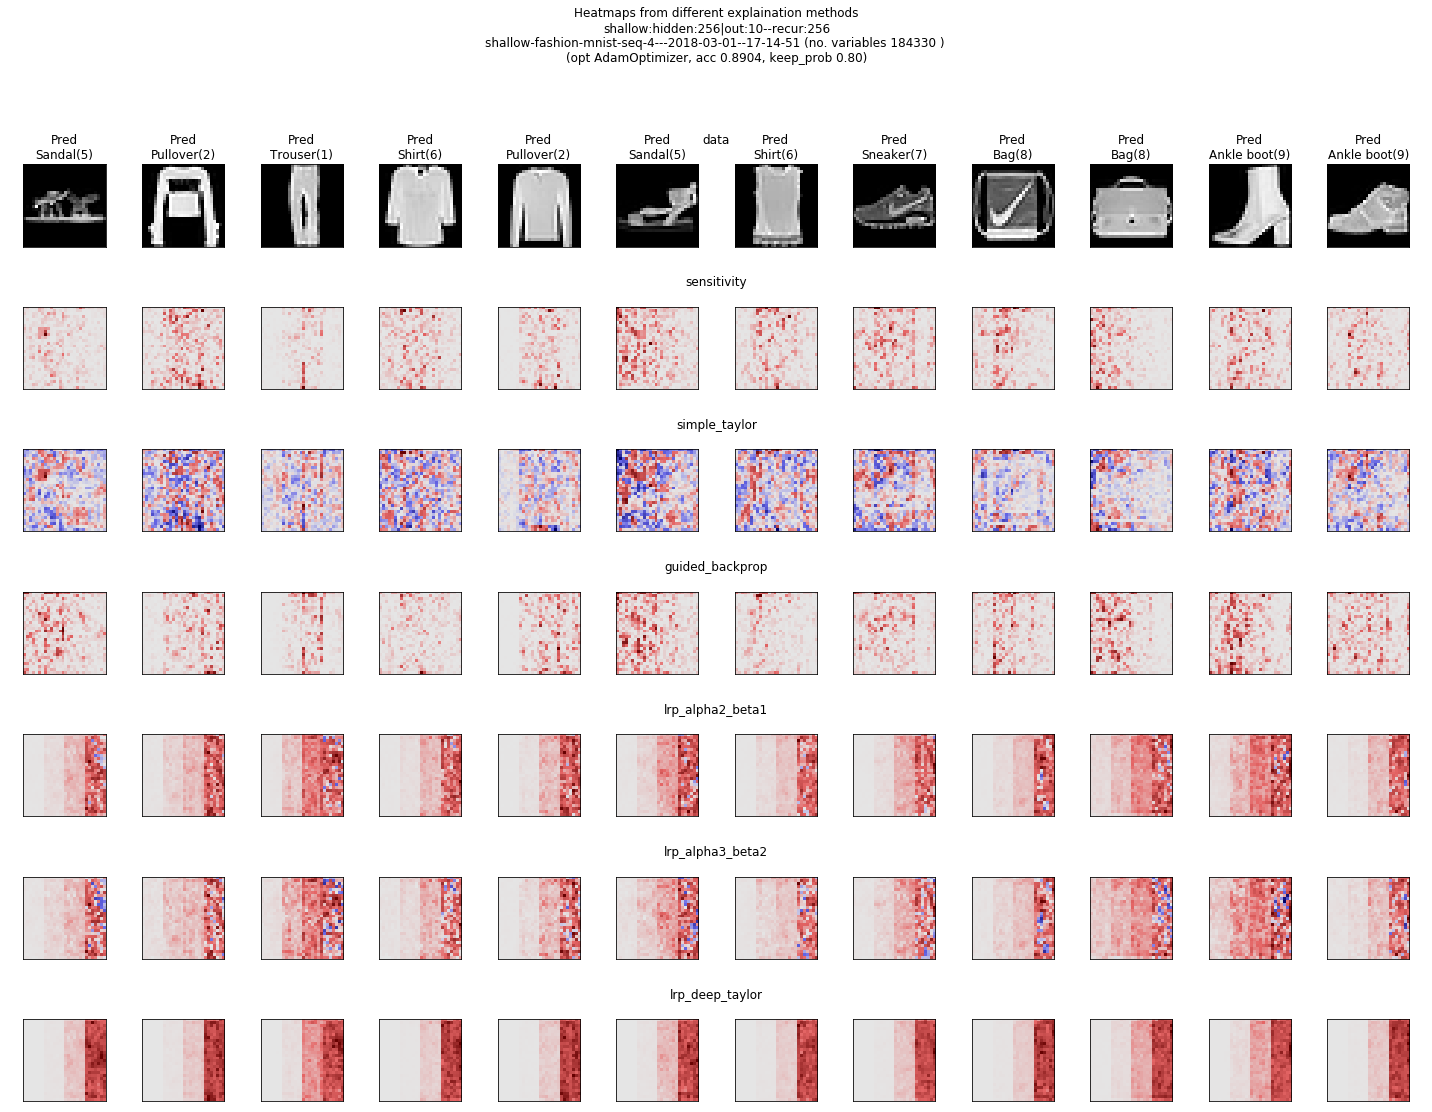

In [23]:
plot_everything('shallow', 'fashion-mnist', 4)

/Users/heytitle/projects/heatmapping-tutorial/src/model/components/layer.py:25: RuntimeWarning: divide by zero encountered in log
  self.b = tf.Variable(tf.ones(dims[-1]) * float(np.log(np.exp(DEFAULT_BIAS_VALUE)-1)), name=b_name)


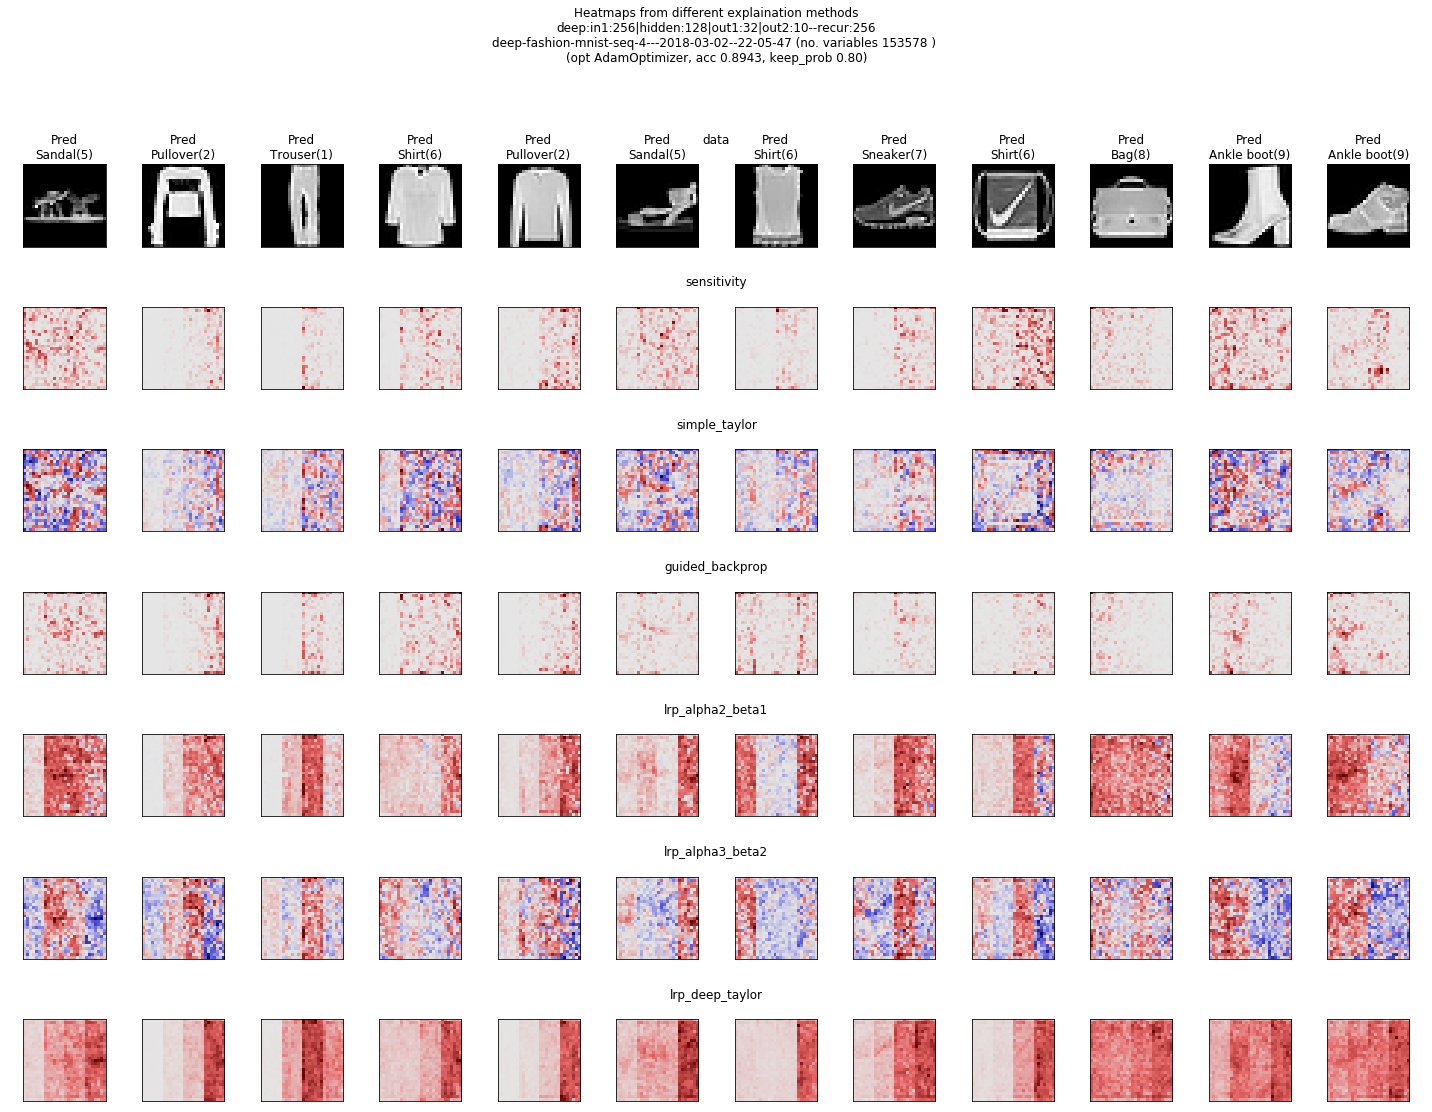

In [24]:
plot_everything('deep', 'fashion-mnist', 4)

/Users/heytitle/projects/heatmapping-tutorial/src/model/components/layer.py:25: RuntimeWarning: divide by zero encountered in log
  self.b = tf.Variable(tf.ones(dims[-1]) * float(np.log(np.exp(DEFAULT_BIAS_VALUE)-1)), name=b_name)


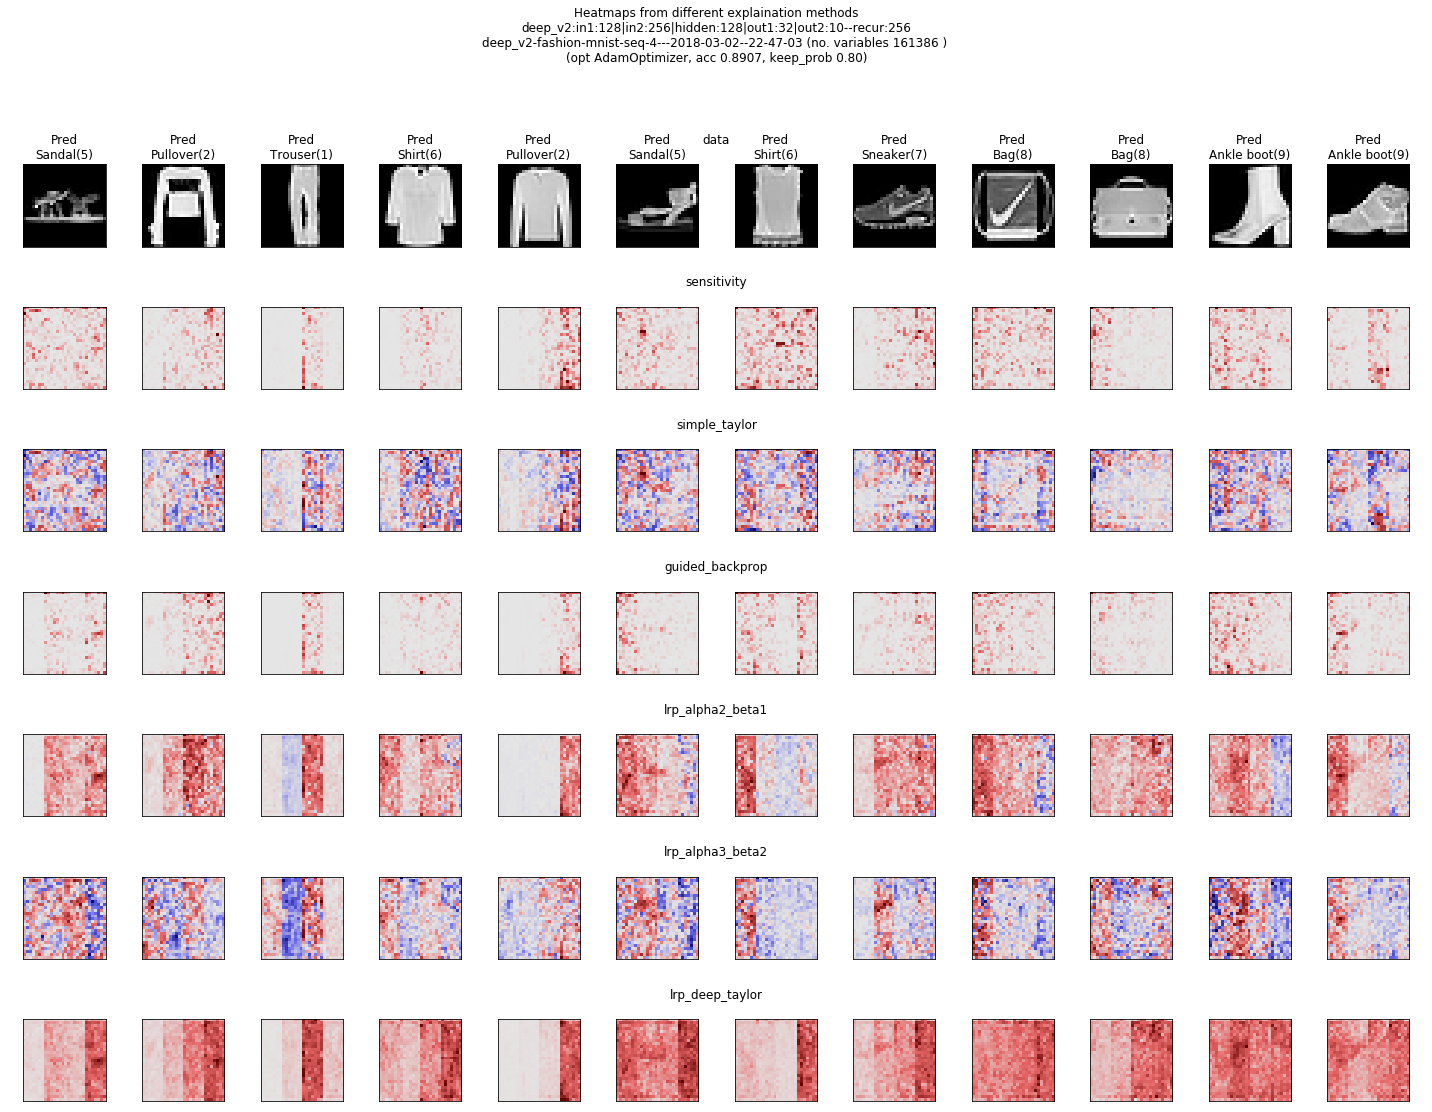

In [25]:
plot_everything('deep_v2', 'fashion-mnist', 4)

/Users/heytitle/projects/heatmapping-tutorial/src/model/components/layer.py:25: RuntimeWarning: divide by zero encountered in log
  self.b = tf.Variable(tf.ones(dims[-1]) * float(np.log(np.exp(DEFAULT_BIAS_VALUE)-1)), name=b_name)


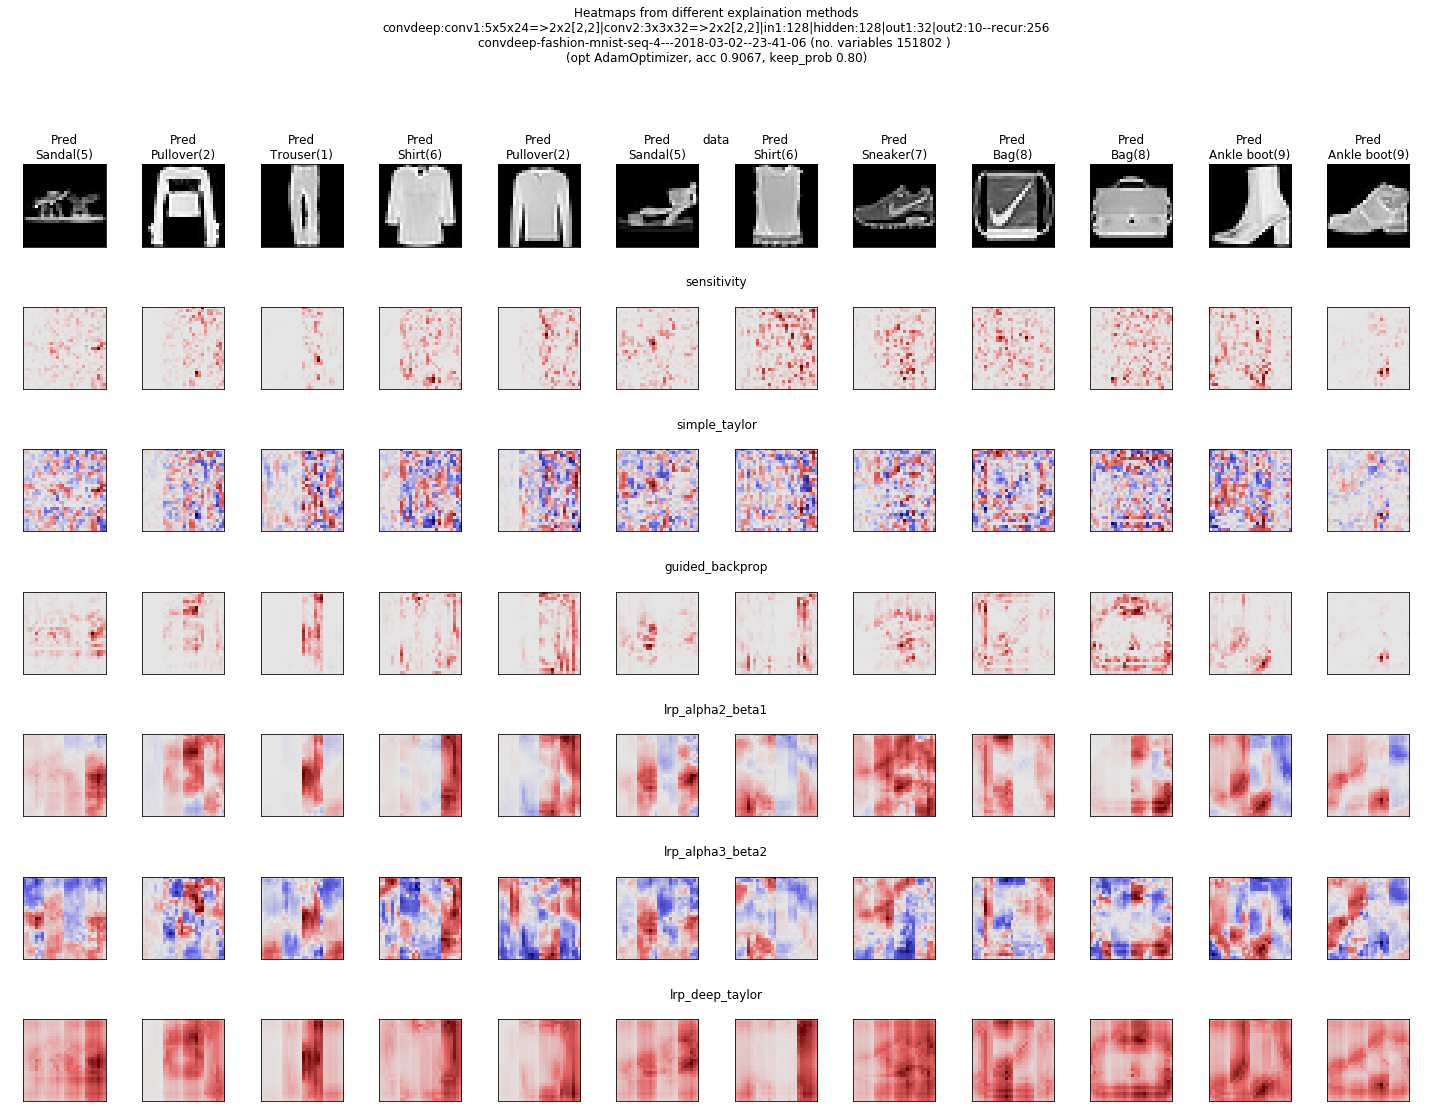

In [26]:
plot_everything('convdeep', 'fashion-mnist', 4)

## Seq 7

### MNIST

/Users/heytitle/projects/heatmapping-tutorial/src/model/components/layer.py:25: RuntimeWarning: divide by zero encountered in log
  self.b = tf.Variable(tf.ones(dims[-1]) * float(np.log(np.exp(DEFAULT_BIAS_VALUE)-1)), name=b_name)


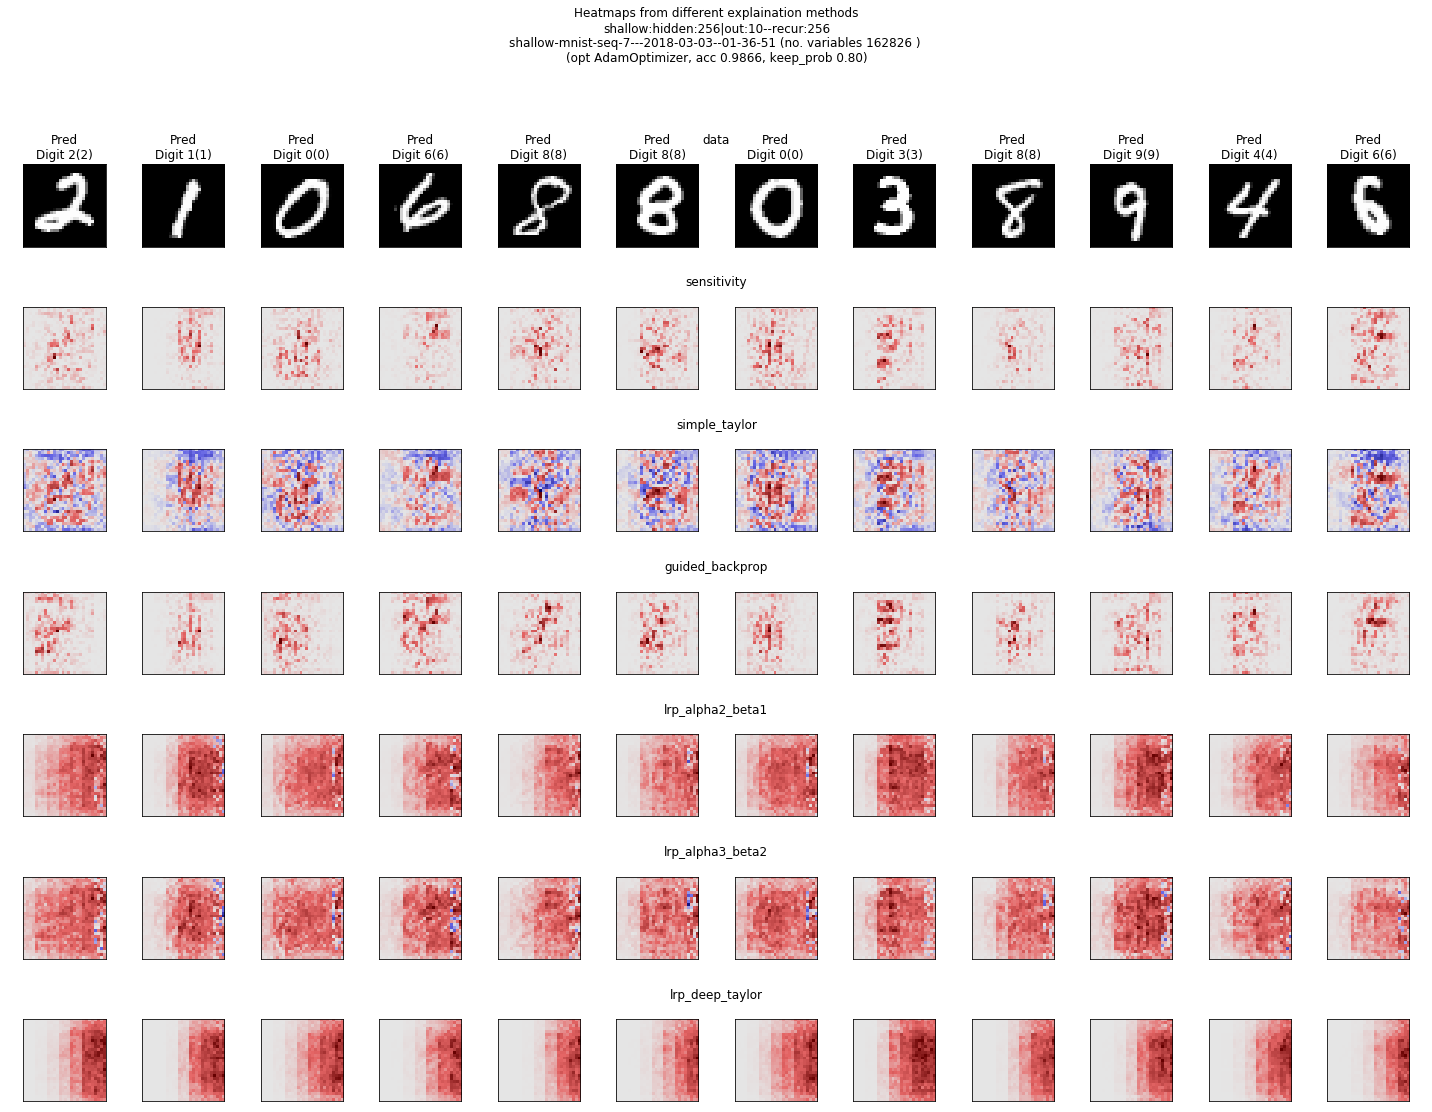

In [27]:
plot_everything('shallow', 'mnist', 7)

/Users/heytitle/projects/heatmapping-tutorial/src/model/components/layer.py:25: RuntimeWarning: divide by zero encountered in log
  self.b = tf.Variable(tf.ones(dims[-1]) * float(np.log(np.exp(DEFAULT_BIAS_VALUE)-1)), name=b_name)


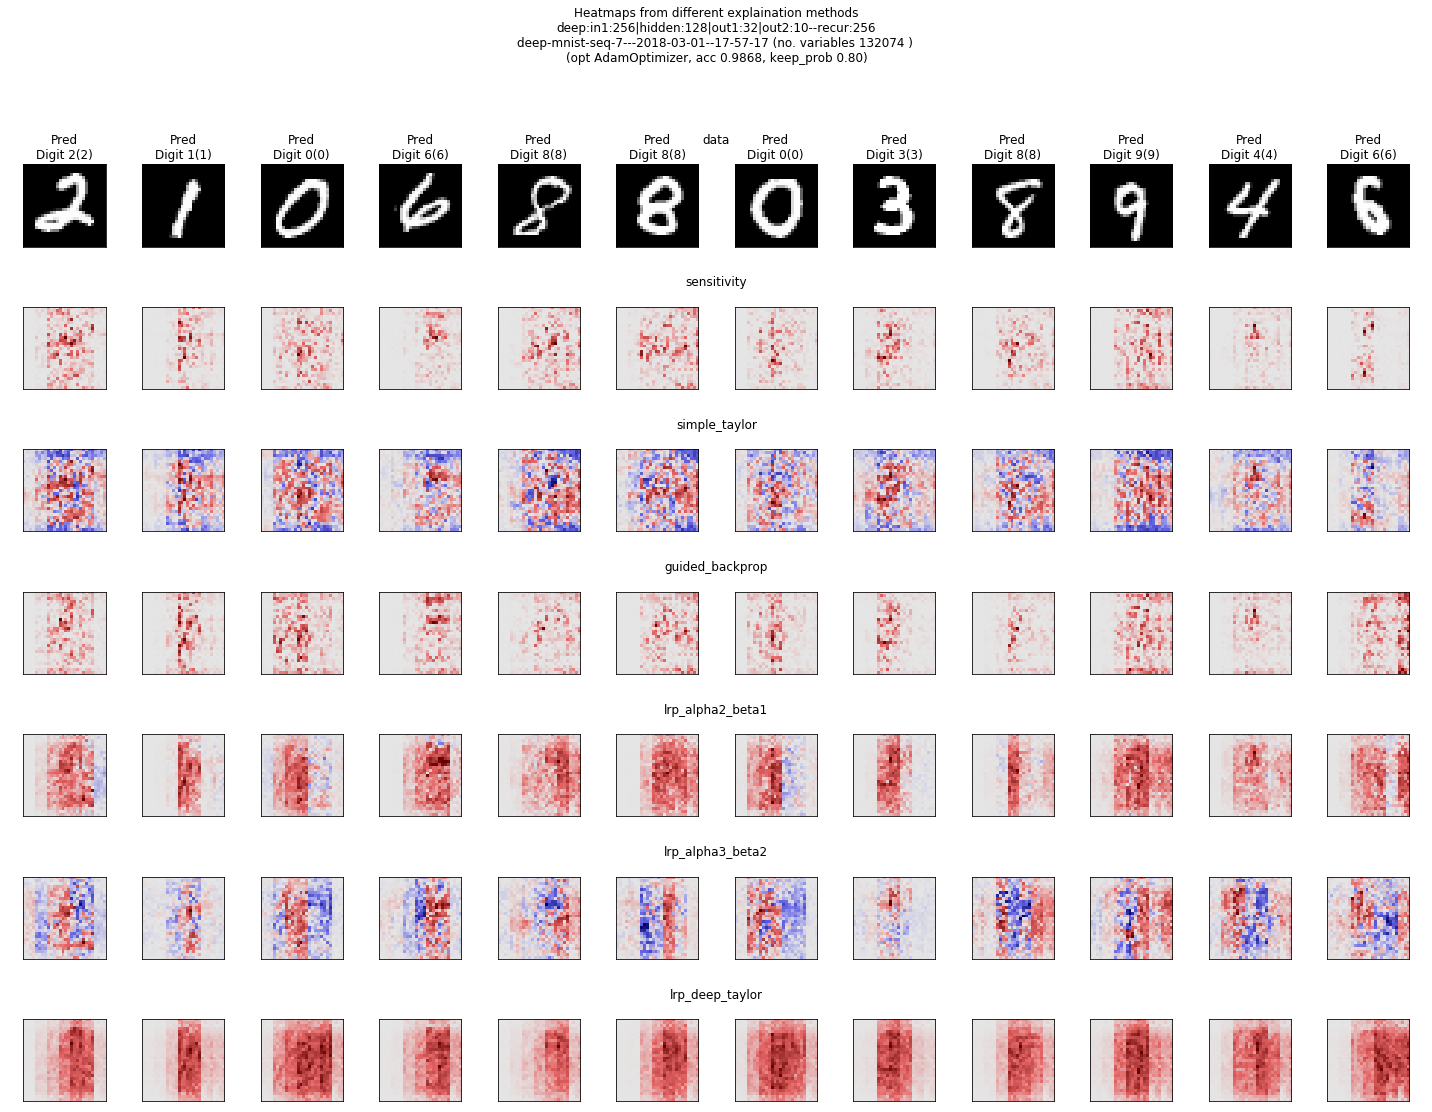

In [28]:
plot_everything('deep', 'mnist', 7)

/Users/heytitle/projects/heatmapping-tutorial/src/model/components/layer.py:25: RuntimeWarning: divide by zero encountered in log
  self.b = tf.Variable(tf.ones(dims[-1]) * float(np.log(np.exp(DEFAULT_BIAS_VALUE)-1)), name=b_name)


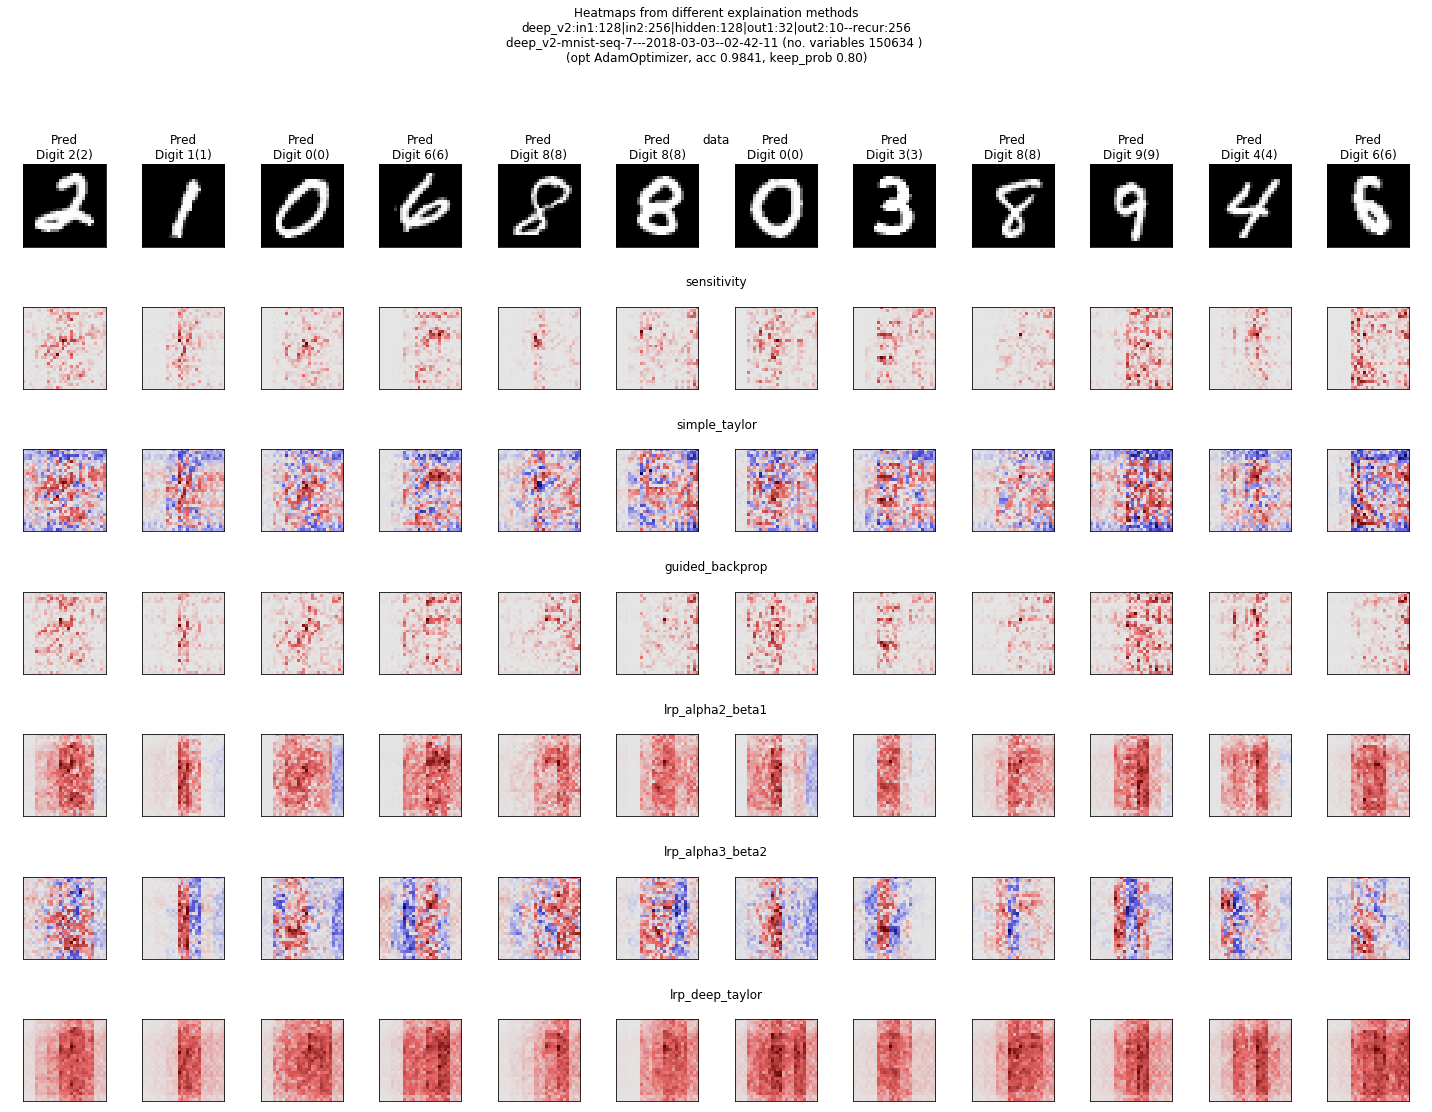

In [29]:
plot_everything('deep_v2', 'mnist', 7)

/Users/heytitle/projects/heatmapping-tutorial/src/model/components/layer.py:25: RuntimeWarning: divide by zero encountered in log
  self.b = tf.Variable(tf.ones(dims[-1]) * float(np.log(np.exp(DEFAULT_BIAS_VALUE)-1)), name=b_name)


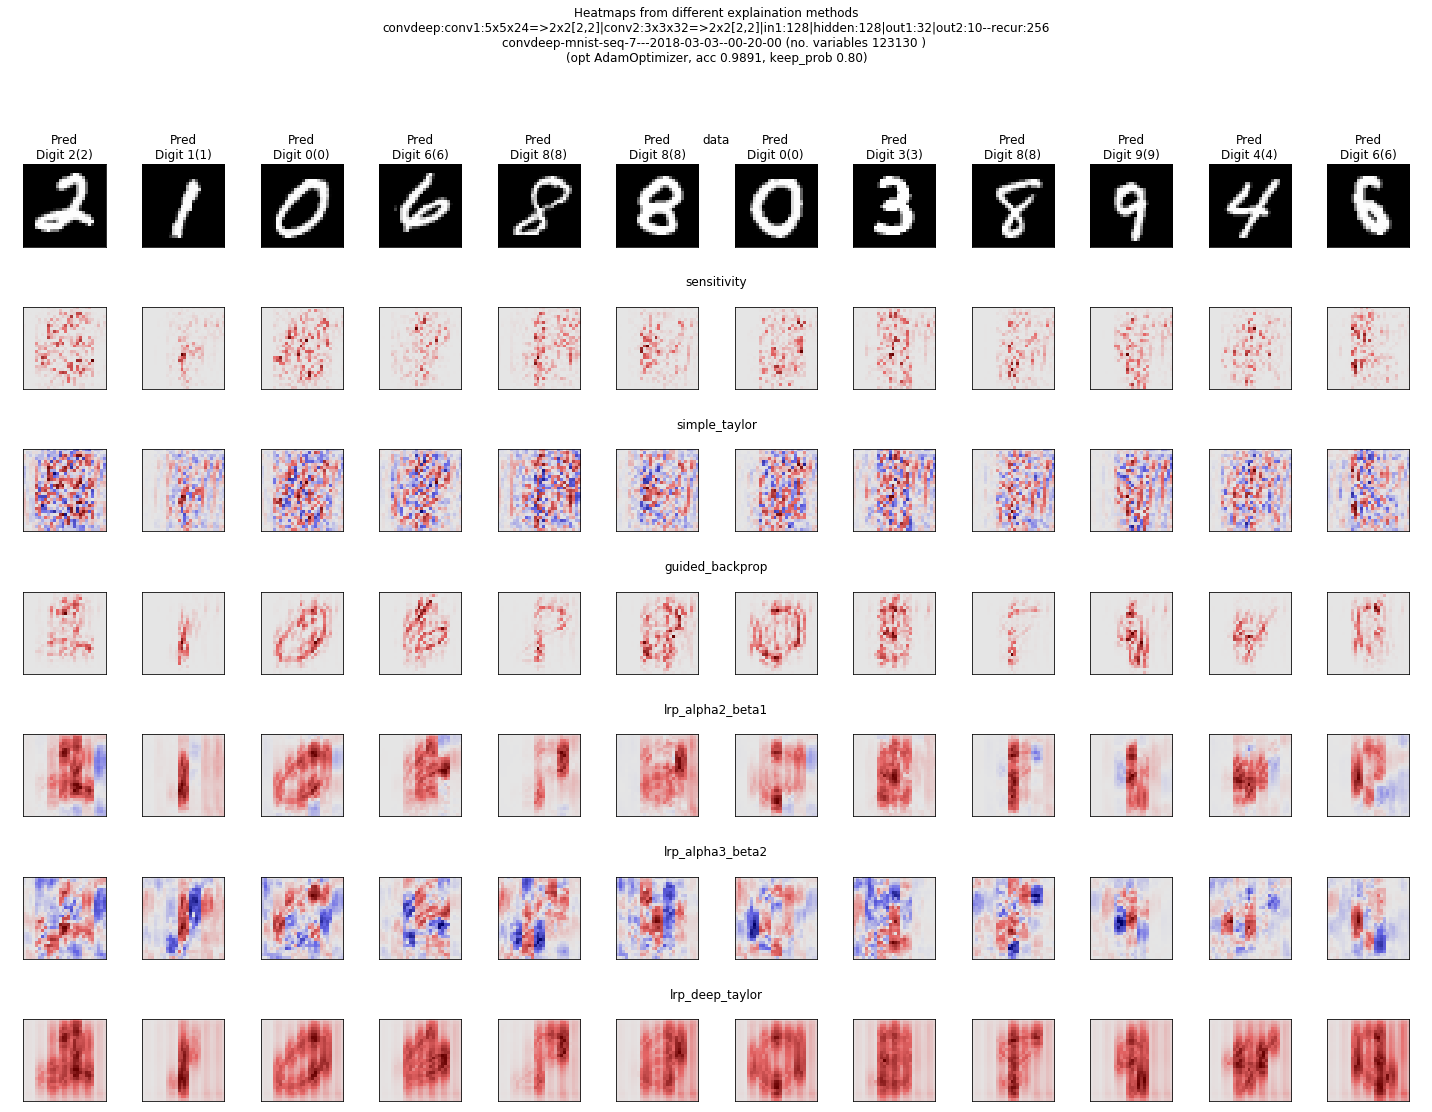

In [30]:
plot_everything('convdeep', 'mnist', 7)

### FashionMNIST

/Users/heytitle/projects/heatmapping-tutorial/src/model/components/layer.py:25: RuntimeWarning: divide by zero encountered in log
  self.b = tf.Variable(tf.ones(dims[-1]) * float(np.log(np.exp(DEFAULT_BIAS_VALUE)-1)), name=b_name)


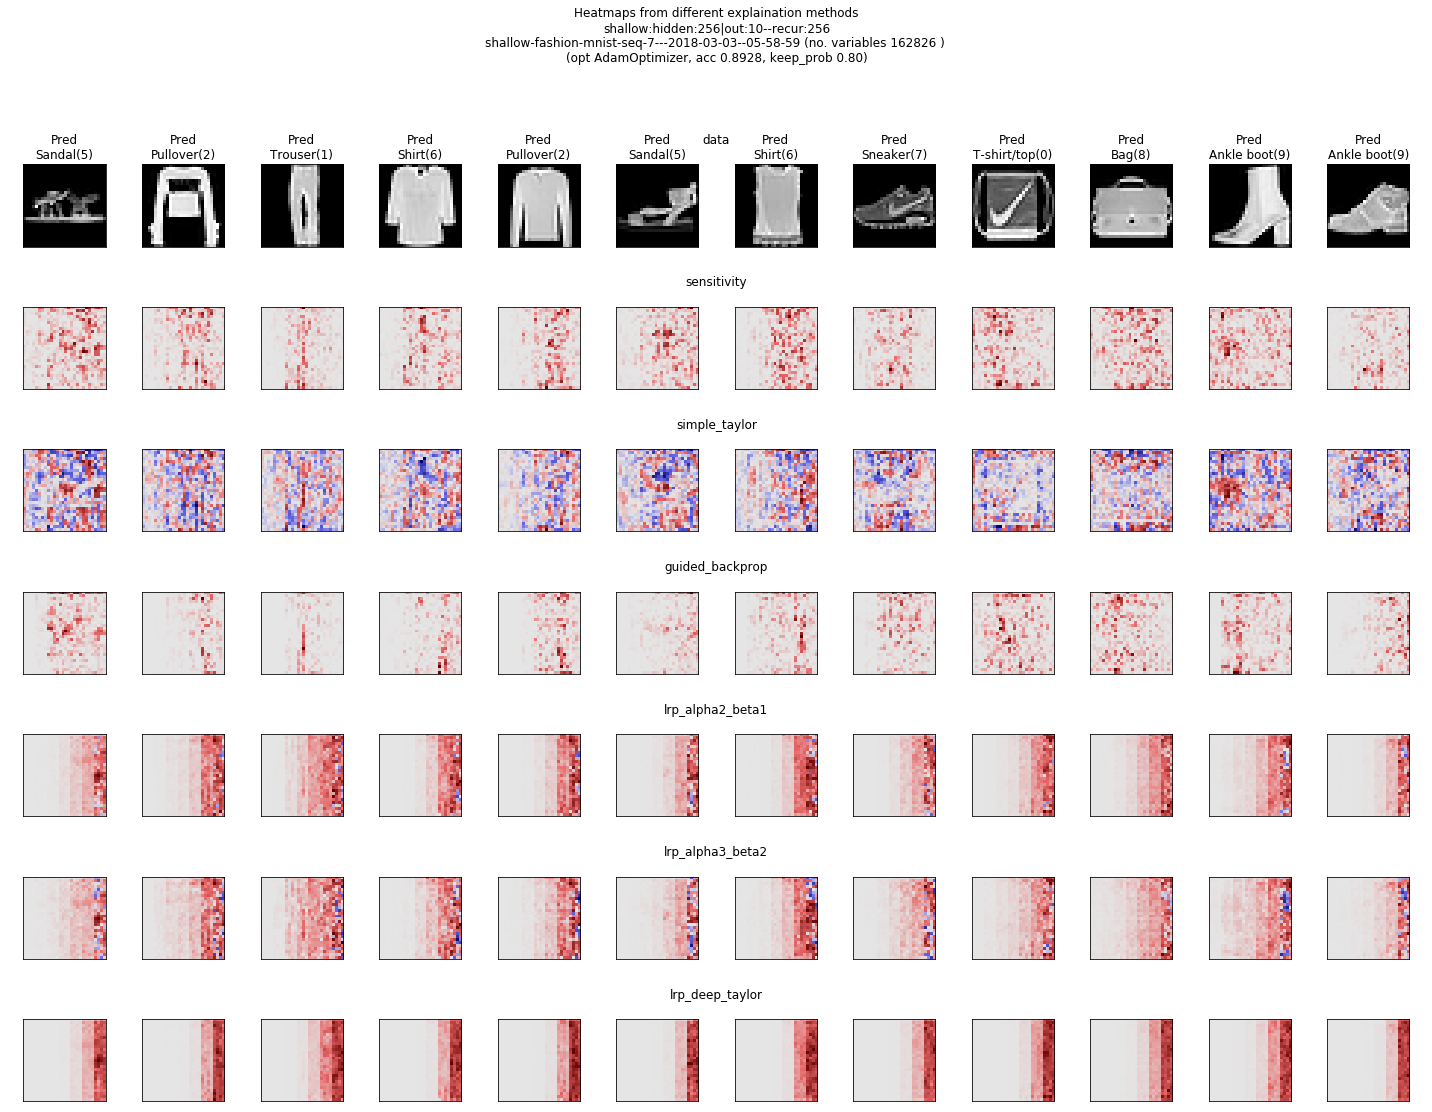

In [31]:
plot_everything('shallow', 'fashion-mnist', 7)

/Users/heytitle/projects/heatmapping-tutorial/src/model/components/layer.py:25: RuntimeWarning: divide by zero encountered in log
  self.b = tf.Variable(tf.ones(dims[-1]) * float(np.log(np.exp(DEFAULT_BIAS_VALUE)-1)), name=b_name)


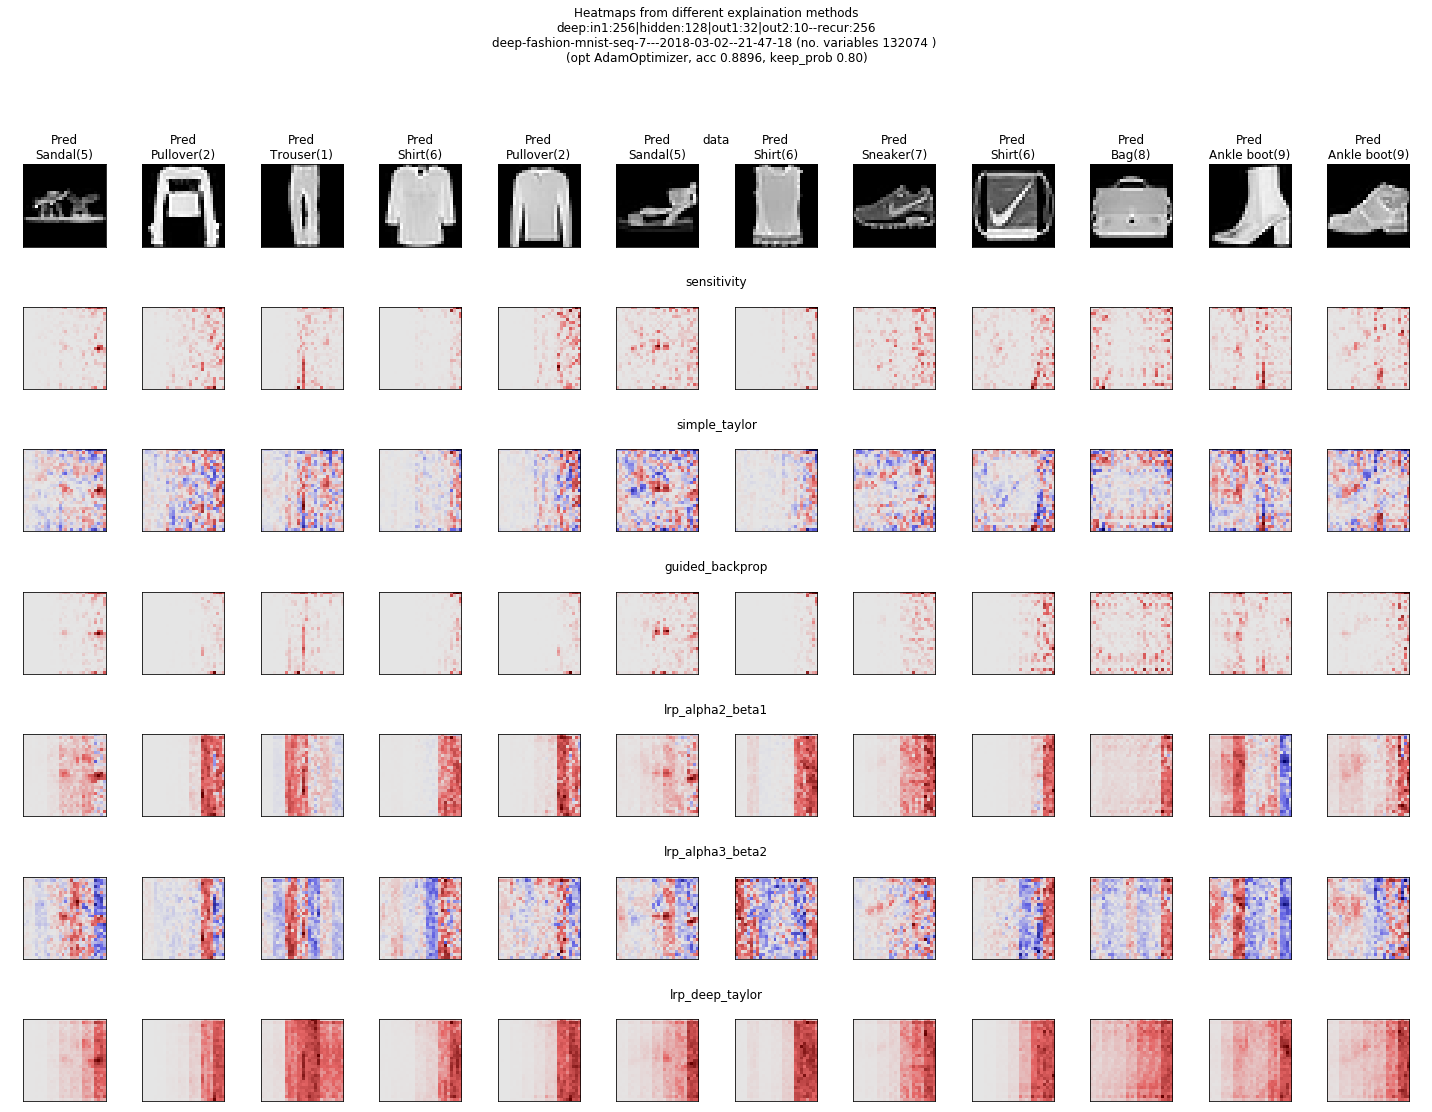

In [32]:
plot_everything('deep', 'fashion-mnist', 7)

/Users/heytitle/projects/heatmapping-tutorial/src/model/components/layer.py:25: RuntimeWarning: divide by zero encountered in log
  self.b = tf.Variable(tf.ones(dims[-1]) * float(np.log(np.exp(DEFAULT_BIAS_VALUE)-1)), name=b_name)


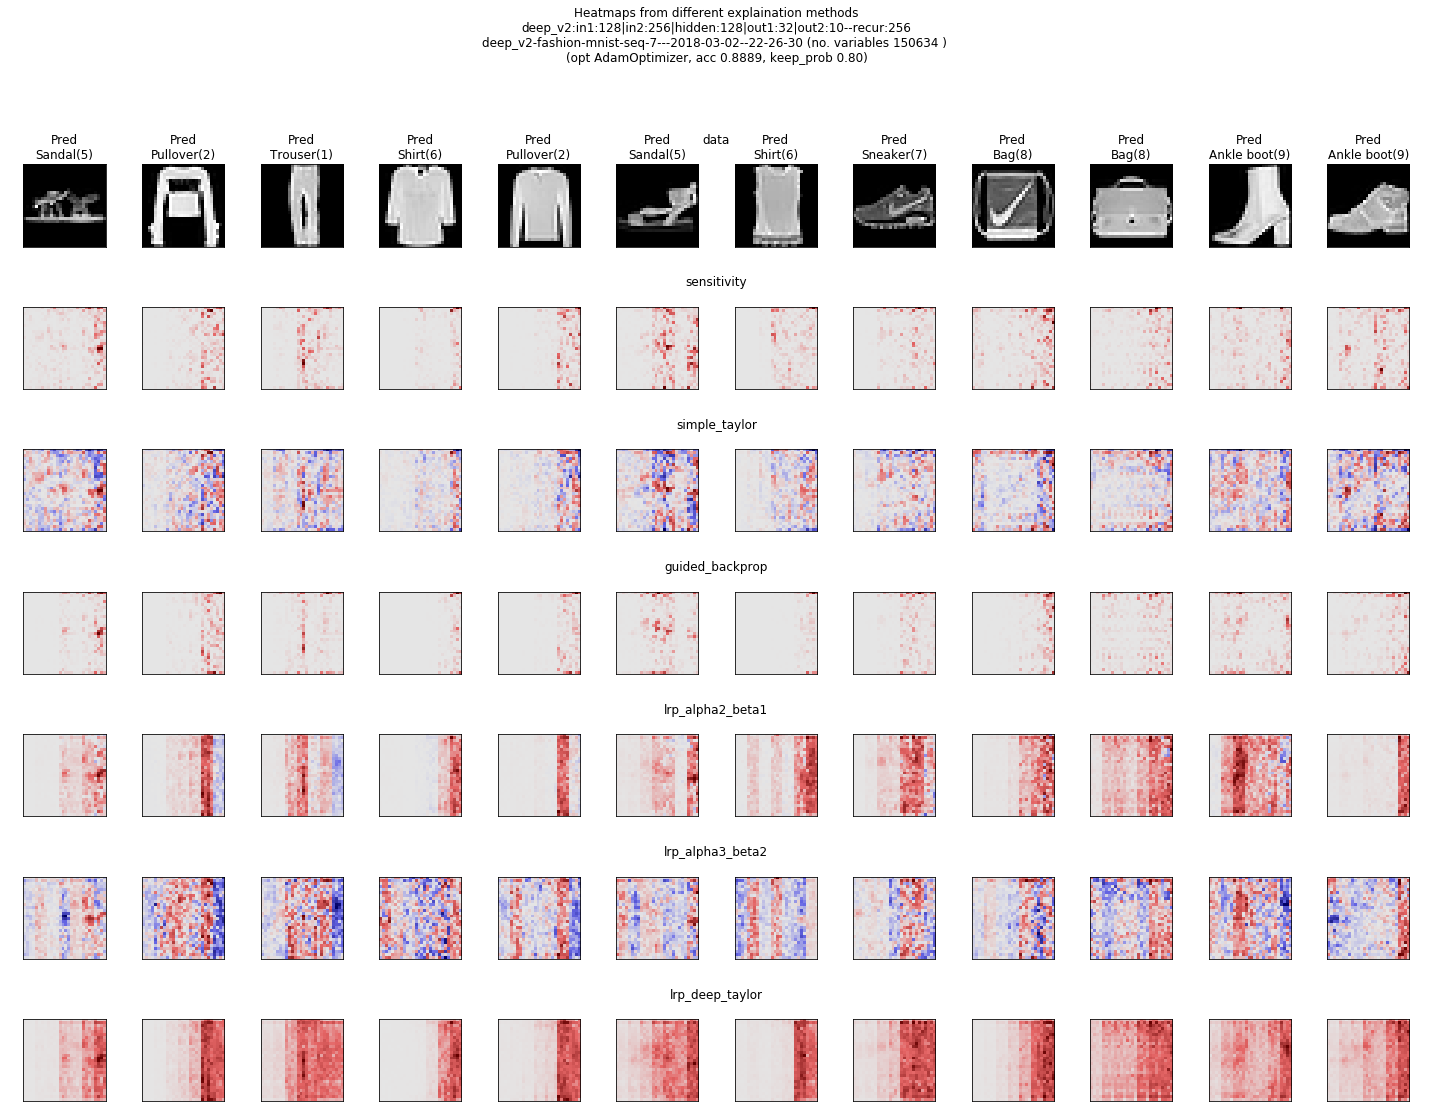

In [33]:
plot_everything('deep_v2', 'fashion-mnist', 7)

/Users/heytitle/projects/heatmapping-tutorial/src/model/components/layer.py:25: RuntimeWarning: divide by zero encountered in log
  self.b = tf.Variable(tf.ones(dims[-1]) * float(np.log(np.exp(DEFAULT_BIAS_VALUE)-1)), name=b_name)


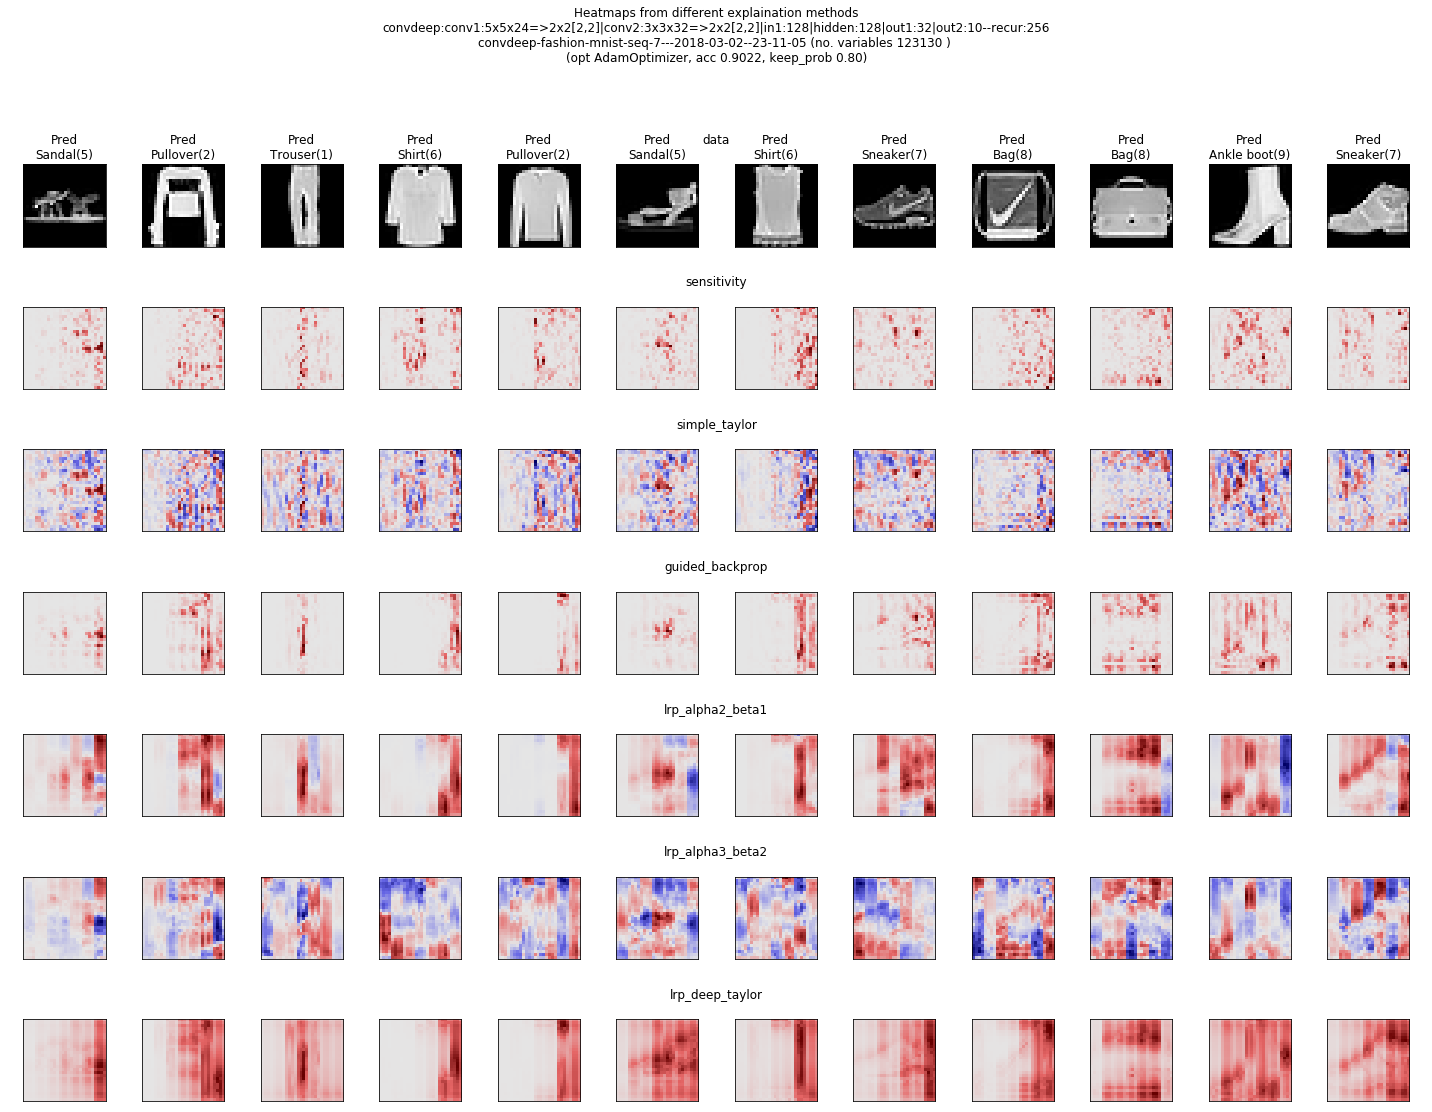

In [35]:
plot_everything('convdeep', 'fashion-mnist', 7)